# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [264]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, silhouette_score, roc_auc_score
from sklearn.preprocessing import Imputer, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import operator
from sklearn.cluster import KMeans
import gc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

We start by loading the general population and the customers data

In [265]:
gen_pop = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
# gen_pop = pd.read_csv('gen_pop.csv')
# customers = pd.read_csv('customers.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


One of the first steps that we're carrying out is to take a look at the top 5 rows of both datasets. On a quick look, they seem to have almost the same features. They have significantly different number of rows however. We will look on how the values of these features differ.

In [300]:
if 'Unnamed: 0' in gen_pop.columns:
    gen_pop.drop(['Unnamed: 0'], axis=1, inplace= True)
if 'Unnamed: 0' in customers.columns:
    customers.drop(['Unnamed: 0'], axis=1, inplace= True)

In [3]:
gen_pop.head()

Unnamed: 0     LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  \
0           0  910215        -1         NaN       NaN          NaN   
1           1  910220        -1         9.0       0.0          NaN   
2           2  910225        -1         9.0      17.0          NaN   
3           3  910226         2         1.0      13.0          NaN   
4           4  910241        -1         1.0      20.0          NaN   

   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ...  VHN  \
0          NaN          NaN          NaN                   NaN  ...  NaN   
1          NaN          NaN          NaN                  21.0  ...  4.0   
2          NaN          NaN          NaN                  17.0  ...  2.0   
3          NaN          NaN          NaN                  13.0  ...  0.0   
4          NaN          NaN          NaN                  14.0  ...  2.0   

   VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0       NaN         NaN      NaN             NaN             NaN       NaN   
1       8.0        11.0     10.0             3.0             9.0       4.0   
2       9.0         9.0      6.0             3.0             9.0       2.0   
3       7.0        10.0     11.0             NaN             9.0       7.0   
4       3.0         5.0      4.0             2.0             9.0       3.0   

   ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0         3         1                    2  
1         5         2                    1  
2         5         2                    3  
3         3         2                    4  
4         4         1                    3  

[5 rows x 367 columns]

In [301]:
customers.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                  10.0                  1.0  ...   
1          NaN          NaN                   NaN                  NaN  ...   
2          NaN          NaN                   0.0                  1.0  ...   
3          NaN          NaN                   8.0                  0.0  ...   
4          NaN          NaN                  14.0                  7.0  ...   

   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  \
0      2.0             6.0             9.0       7.0         3   
1      3.0             0.0             9.0       NaN         3   
2     11.0             6.0             9.0       2.0         3   
3      2.0             NaN             9.0       7.0         1   
4      4.0             2.0             9.0       3.0         1   

       PRODUCT_GROUP  CUSTOMER_GROUP ONLINE_PURCHASE ANREDE_KZ  \
0  COSMETIC_AND_FOOD     MULTI_BUYER               0         1   
1               FOOD    SINGLE_BUYER               0         1   
2  COSMETIC_AND_FOOD     MULTI_BUYER               0         2   
3           COSMETIC     MULTI_BUYER               0         1   
4               FOOD     MULTI_BUYER               0         1   

  ALTERSKATEGORIE_GROB  
0                    4  
1                    4  
2                    4  
3                    4  
4                    3  

[5 rows x 369 columns]

Here we investigate the size of the two datasets and we can see that the general population dataset is significantly larger with a size of 2.7 GB for its 891221 rows as oppose to the 613.7 MB for the 191652 rows of the customers dataset. We will attempt to tackle this size issue by setting the columns to the right type in the preprocessing section.

Another point that is addressed below is the features present in the customer dataset but not in the general population. These are: 'ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP'

In [9]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
gen_pop.info(memory_usage='deep')
print('\n')
customers.info(memory_usage='deep')
print('\n number of columns in general population:', len(gen_pop.columns))
print('\n number of columns in customers:', len(customers.columns), '\n')
print(set(customers.columns)-set(gen_pop.columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.7 GB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 613.7 MB

 number of columns in general population: 366

 number of columns in customers: 369 

{'ONLINE_PURCHASE', 'CUSTOMER_GROUP', 'PRODUCT_GROUP'}


In the two cells below we look at different attributes for each feature such as the mean, the min and max values. The difference between the two datasets is not easily discerned using the table form and given the large number of features. Therefore we will attempt to visualize these differences.

In [10]:
customers.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  191652.000000  191652.000000  145056.000000  145056.000000   
mean    95826.500000       0.344359       1.747525      11.352009   
std     55325.311233       1.391672       1.966334       6.275026   
min         1.000000      -1.000000       1.000000       0.000000   
25%     47913.750000      -1.000000       1.000000       8.000000   
50%     95826.500000       0.000000       1.000000      11.000000   
75%    143739.250000       2.000000       1.000000      16.000000   
max    191652.000000       3.000000       9.000000      21.000000   

        ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  11766.000000  5100.000000  1275.000000   236.000000   
mean      12.337243    13.672353    14.647059    15.377119   
std        4.006050     3.243335     2.753787     2.307653   
min        2.000000     2.000000     5.000000     8.000000   
25%        9.000000    11.000000    13.000000    14.000000   
50%       13.000000    14.000000    15.000000    16.000000   
75%       16.000000    16.000000    17.000000    17.000000   
max       18.000000    18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...       VK_DHT4A  \
count         139810.000000        141725.000000  ...  143781.000000   
mean              10.331579             4.965863  ...       4.374417   
std                4.134828            14.309694  ...       2.924355   
min                0.000000             0.000000  ...       1.000000   
25%                9.000000             1.000000  ...       2.000000   
50%               10.000000             1.000000  ...       4.000000   
75%               13.000000             4.000000  ...       7.000000   
max               25.000000           523.000000  ...      11.000000   

          VK_DISTANZ        VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
count  143781.000000  143781.000000   137910.000000   145056.000000   
mean        4.564769       3.168868        4.152716        8.646371   
std         2.887035       2.233516        1.974375        1.154001   
min         1.000000       1.000000        0.000000        1.000000   
25%         2.000000       1.000000        2.000000        9.000000   
50%         4.000000       3.000000        5.000000        9.000000   
75%         7.000000       4.000000        6.000000        9.000000   
max        13.000000      11.000000        6.000000        9.000000   

            WOHNLAGE       ZABEOTYP  ONLINE_PURCHASE      ANREDE_KZ  \
count  141725.000000  191652.000000    191652.000000  191652.000000   
mean        3.723133       2.576806         0.090247       1.376432   
std         2.095540       1.168486         0.286536       0.484492   
min         0.000000       1.000000         0.000000       1.000000   
25%         2.000000       1.000000         0.000000       1.000000   
50%         3.000000       3.000000         0.000000       1.000000   
75%         5.000000       3.000000         0.000000       2.000000   
max         8.000000       6.000000         1.000000       2.000000   

       ALTERSKATEGORIE_GROB  
count         191652.000000  
mean               3.060907  
std                1.086254  
min                1.000000  
25%                3.000000  
50%                3.000000  
75%                4.000000  
max                9.000000  

[8 rows x 361 columns]

In [11]:
gen_pop.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50%       12.000000     14.000000    15.000000    15.000000   
75%       15.000000     16.000000    17.000000    17.000000   
max       18.000000     18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...            VHN  \
count         628274.000000        798073.000000  ...  770025.000000   
mean              13.700717             8.287263  ...       2.417322   
std                5.079849            15.628087  ...       1.166572   
min                0.000000             0.000000  ...       0.000000   
25%               11.000000             1.000000  ...       2.000000   
50%               14.000000             4.000000  ...       2.000000   
75%               17.000000             9.000000  ...       3.000000   
max               25.000000           595.000000  ...       4.000000   

            VK_DHT4A     VK_DISTANZ        VK_ZG11  W_KEIT_KIND_HH  \
count  815304.000000  815304.000000  815304.000000   783619.000000   
mean        6.001214       7.532130       5.945972        3.933406   
std         2.856091       3.247789       2.771464        1.964701   
min         1.000000       1.000000       1.000000        0.000000   
25%         3.000000       5.000000       4.000000        2.000000   
50%         6.000000       8.000000       6.000000        4.000000   
75%         9.000000      10.000000       8.000000        6.000000   
max        11.000000      13.000000      11.000000        6.000000   

       WOHNDAUER_2008       WOHNLAGE       ZABEOTYP      ANREDE_KZ  \
count   817722.000000  798073.000000  891221.000000  891221.000000   
mean         7.908791       4.052836       3.362438       1.522098   
std          1.923137       1.949539       1.352704       0.499512   
min          1.000000       0.000000       1.000000       1.000000   
25%          8.000000       3.000000       3.000000       1.000000   
50%          9.000000       3.000000       3.000000       2.000000   
75%          9.000000       5.000000       4.000000       2.000000   
max          9.000000       8.000000       6.000000       2.000000   

       ALTERSKATEGORIE_GROB  
count         891221.000000  
mean               2.777398  
std                1.068775  
min                1.000000  
25%                2.000000  
50%                3.000000  
75%                4.000000  
max                9.000000  

[8 rows x 360 columns]

The two cells below highlights the top columns in terms of size. These seem to be of an object or categorical type

In [12]:
(gen_pop.memory_usage(deep=True) * 1e-6).sort_values(ascending= False)[:10]

EINGEFUEGT_AM               63.634284
OST_WEST_KZ                 55.653554
D19_LETZTER_KAUF_BRANCHE    53.480219
CAMEO_DEU_2015              49.909606
CAMEO_DEUG_2015             44.137244
CAMEO_INTL_2015             40.921738
KBA05_ANTG1                  7.129768
INNENSTADT                   7.129768
KBA05_ALTER1                 7.129768
KBA05_ALTER2                 7.129768
dtype: float64

In [13]:
(customers.memory_usage(deep=True) * 1e-6).sort_values(ascending= False)[:10]

PRODUCT_GROUP               13.175592
CUSTOMER_GROUP              13.091750
EINGEFUEGT_AM               12.368764
D19_LETZTER_KAUF_BRANCHE    11.792569
OST_WEST_KZ                 10.951514
CAMEO_DEU_2015               9.945912
CAMEO_DEUG_2015              9.709596
CAMEO_INTL_2015              8.973210
ALTERSKATEGORIE_GROB         1.533216
KBA05_ANHANG                 1.533216
dtype: float64

In [266]:
cols = gen_pop.columns
num_cols_gen = gen_pop._get_numeric_data().columns
non_numeric_col_gen_pop = list(set(cols) - set(num_cols_gen))

In [267]:
non_numeric_col_gen_pop

['CAMEO_DEUG_2015',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ',
 'D19_LETZTER_KAUF_BRANCHE',
 'CAMEO_INTL_2015',
 'CAMEO_DEU_2015']

In [268]:
cols = customers.columns
num_cols = customers._get_numeric_data().columns
non_numeric_col_customers = list(set(cols) - set(num_cols))

In [269]:
non_numeric_col_customers

['PRODUCT_GROUP',
 'CAMEO_DEUG_2015',
 'EINGEFUEGT_AM',
 'CUSTOMER_GROUP',
 'OST_WEST_KZ',
 'D19_LETZTER_KAUF_BRANCHE',
 'CAMEO_INTL_2015',
 'CAMEO_DEU_2015']

Exploring the correlation between the different features

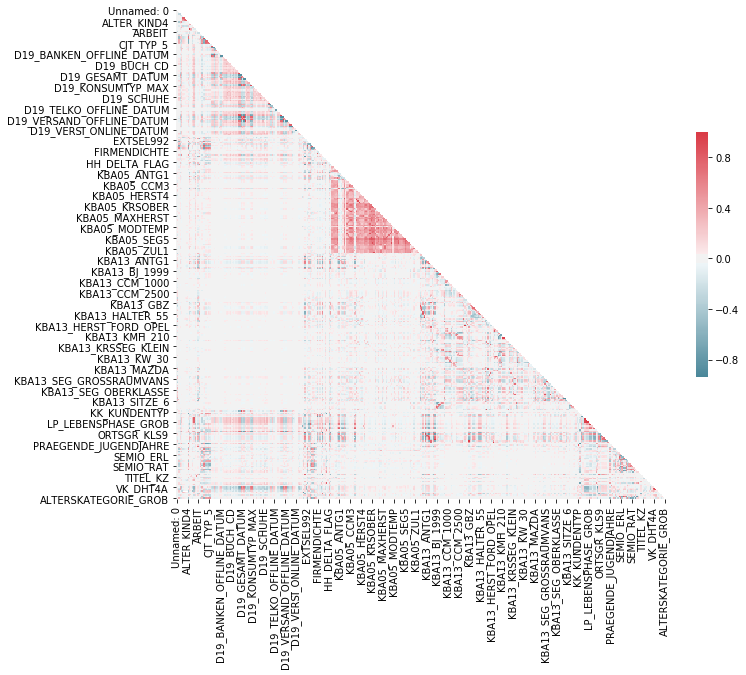

In [270]:
corr = gen_pop[num_cols_gen].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, cbar_kws={"shrink": .5})

Starting with loading the trainning and testing data

In [272]:
df_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
df_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
# df_train = pd.read_csv('df_train.csv')
# df_test = pd.read_csv('df_test.csv')

Dropping the Unnamed: 0 column

In [339]:
if 'Unnamed: 0' in df_train.columns:
    df_train.drop(['Unnamed: 0'], axis=1, inplace= True)
if 'Unnamed: 0' in df_test.columns:
    df_test.drop(['Unnamed: 0'], axis=1, inplace= True)

Checking the shape of both datasets

In [273]:
print(df_train.shape)
print(df_test.shape)

(42962, 368)
(42833, 367)


Adjusting the df_train shape to match the df_test in order to simplify the plotting process

In [275]:
df_train = df_train.iloc[:42833,:]

The next two cells describe the dataset in terms of mean, min, max, etc. The differences will be highlighted in the upcoming plots.

In [24]:
df_train.describe()

LNR      AGER_TYP    AKT_DAT_KL      ALTER_HH  ALTER_KIND1  \
count  42833.000000  42833.000000  35880.000000  35880.000000  1986.000000   
mean   42835.296454      0.542105      1.525334     10.290245    12.608258   
std    24790.632421      1.412944      1.741935      6.084463     3.926351   
min        1.000000     -1.000000      1.000000      0.000000     2.000000   
25%    21304.000000     -1.000000      1.000000      8.000000     9.000000   
50%    42794.000000      1.000000      1.000000     10.000000    13.000000   
75%    64366.000000      2.000000      1.000000     15.000000    16.000000   
max    85795.000000      3.000000      9.000000     21.000000    18.000000   

       ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  \
count   755.000000   174.000000    41.000000          34696.000000   
mean     13.785430    14.655172    14.195122              9.855949   
std       3.067162     2.615329     3.034959              4.374407   
min       5.000000     6.000000     6.000000              0.000000   
25%      12.000000    13.000000    13.000000              8.000000   
50%      14.000000    15.000000    15.000000             10.000000   
75%      16.000000    17.000000    17.000000             13.000000   
max      18.000000    18.000000    18.000000             25.000000   

       ANZ_HAUSHALTE_AKTIV  ...      VK_DHT4A    VK_DISTANZ       VK_ZG11  \
count         35074.000000  ...  35583.000000  35583.000000  35583.000000   
mean              6.695387  ...      4.317652      4.505269      3.116825   
std              15.109469  ...      3.164883      3.289605      2.534631   
min               0.000000  ...      1.000000      1.000000      1.000000   
25%               1.000000  ...      1.000000      2.000000      1.000000   
50%               2.000000  ...      3.000000      4.000000      2.000000   
75%               7.000000  ...      7.000000      7.000000      4.000000   
max             438.000000  ...     11.000000     13.000000     11.000000   

       W_KEIT_KIND_HH  WOHNDAUER_2008      WOHNLAGE      ZABEOTYP  \
count    33181.000000    35880.000000  35074.000000  42833.000000   
mean         4.487297        8.730100      4.059845      2.804076   
std          1.890125        1.010057      2.046597      1.121264   
min          0.000000        1.000000      0.000000      1.000000   
25%          3.000000        9.000000      3.000000      3.000000   
50%          6.000000        9.000000      3.000000      3.000000   
75%          6.000000        9.000000      7.000000      3.000000   
max          6.000000        9.000000      8.000000      6.000000   

           RESPONSE     ANREDE_KZ  ALTERSKATEGORIE_GROB  
count  42833.000000  42833.000000          42833.000000  
mean       0.012397      1.595149              3.213504  
std        0.110651      0.490869              1.067599  
min        0.000000      1.000000              1.000000  
25%        0.000000      1.000000              3.000000  
50%        0.000000      2.000000              4.000000  
75%        0.000000      2.000000              4.000000  
max        1.000000      2.000000              9.000000  

[8 rows x 361 columns]

In [43]:
df_test.describe()

LNR      AGER_TYP    AKT_DAT_KL      ALTER_HH  ALTER_KIND1  \
count  42833.000000  42833.000000  35944.000000  35944.000000  2013.000000   
mean   42993.165620      0.537436      1.518890     10.239511    12.534029   
std    24755.599728      1.414777      1.737441      6.109680     3.996079   
min        2.000000     -1.000000      1.000000      0.000000     2.000000   
25%    21650.000000     -1.000000      1.000000      8.000000     9.000000   
50%    43054.000000      1.000000      1.000000     10.000000    13.000000   
75%    64352.000000      2.000000      1.000000     15.000000    16.000000   
max    85794.000000      3.000000      9.000000     21.000000    18.000000   

       ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  \
count   762.000000   201.000000    39.000000          34715.000000   
mean     13.942257    14.442786    14.410256              9.822584   
std       3.142155     2.787106     2.279404              4.410937   
min       4.000000     6.000000     9.000000              0.000000   
25%      12.000000    13.000000    13.000000              8.000000   
50%      14.000000    15.000000    14.000000             10.000000   
75%      17.000000    17.000000    16.000000             13.000000   
max      18.000000    18.000000    18.000000             25.000000   

       ANZ_HAUSHALTE_AKTIV  ...           VHN      VK_DHT4A    VK_DISTANZ  \
count         35206.000000  ...  34530.000000  35658.000000  35658.000000   
mean              6.749986  ...      2.372401      4.308682      4.488474   
std              14.839779  ...      1.151531      3.169149      3.274829   
min               0.000000  ...      0.000000      1.000000      1.000000   
25%               1.000000  ...      2.000000      1.000000      2.000000   
50%               2.000000  ...      2.000000      3.000000      4.000000   
75%               7.000000  ...      3.000000      7.000000      7.000000   
max             379.000000  ...      4.000000     11.000000     13.000000   

            VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008      WOHNLAGE  \
count  35658.000000    33214.000000    35944.000000  35206.000000   
mean       3.090078        4.489282        8.727437      4.088280   
std        2.510134        1.886903        1.013702      2.053977   
min        1.000000        0.000000        1.000000      0.000000   
25%        1.000000        3.000000        9.000000      3.000000   
50%        2.000000        6.000000        9.000000      3.000000   
75%        4.000000        6.000000        9.000000      7.000000   
max       11.000000        6.000000        9.000000      8.000000   

           ZABEOTYP     ANREDE_KZ  ALTERSKATEGORIE_GROB  
count  42833.000000  42833.000000          42833.000000  
mean       2.800037      1.595475              3.220484  
std        1.120624      0.490806              1.069753  
min        1.000000      1.000000              1.000000  
25%        3.000000      1.000000              3.000000  
50%        3.000000      2.000000              4.000000  
75%        3.000000      2.000000              4.000000  
max        6.000000      2.000000              9.000000  

[8 rows x 360 columns]

Below we plot the response distribution within the training data. We can see that the data is unbalanced with respect to the response

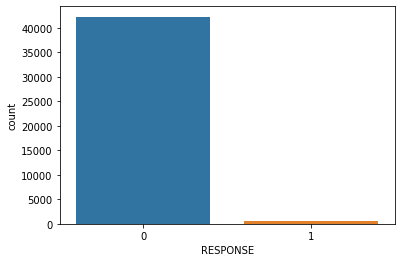

In [277]:
sns.countplot(df_train['RESPONSE'])
plt.savefig('skewed_response.png')

In [60]:
print("There are {}% response values with 1".format(100 * df_train["RESPONSE"].value_counts()[1]/df_train.shape[0]))

There are 1.2396983634113885% response values with 1


In [289]:
# from https://www.kaggle.com/gpreda/santander-eda-and-prediction
def plot_feature_distribution(df1, df2, label1, label2, features, col=10):
    """ A function that ploter the feature distribution
    Inputs:
    df1, df2: the comparsion dataframes
    labels: labeling the two distributions
    features: the feature to be compared on
    
    """
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(col,10,i)
        try:
            sns.distplot(df1[feature], hist=False,label=label1)
        except:
            pass
        try:
            sns.distplot(df2[feature], hist=False,label=label2)
        except:
            pass
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.savefig('response_0_vs_1_in_train.png')
    plt.show();

Here we explore the features distribution in the training data between those with a response and those with none

<Figure size 432x288 with 0 Axes>

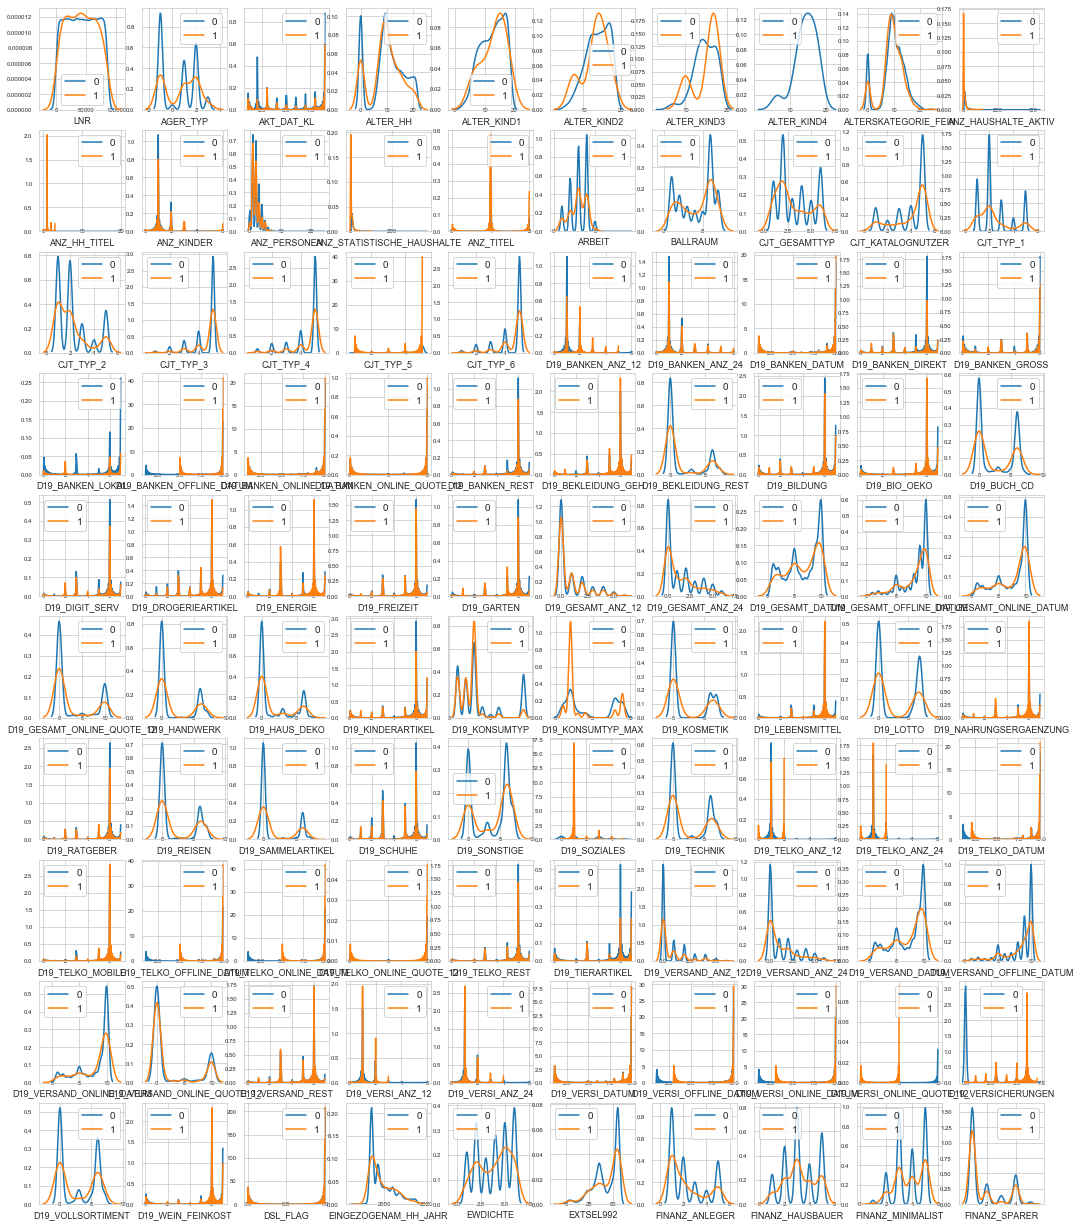

In [290]:
t0 = df_train.loc[df_train['RESPONSE'] == 0]
t1 = df_train.loc[df_train['RESPONSE'] == 1]
features = num_cols[:100]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

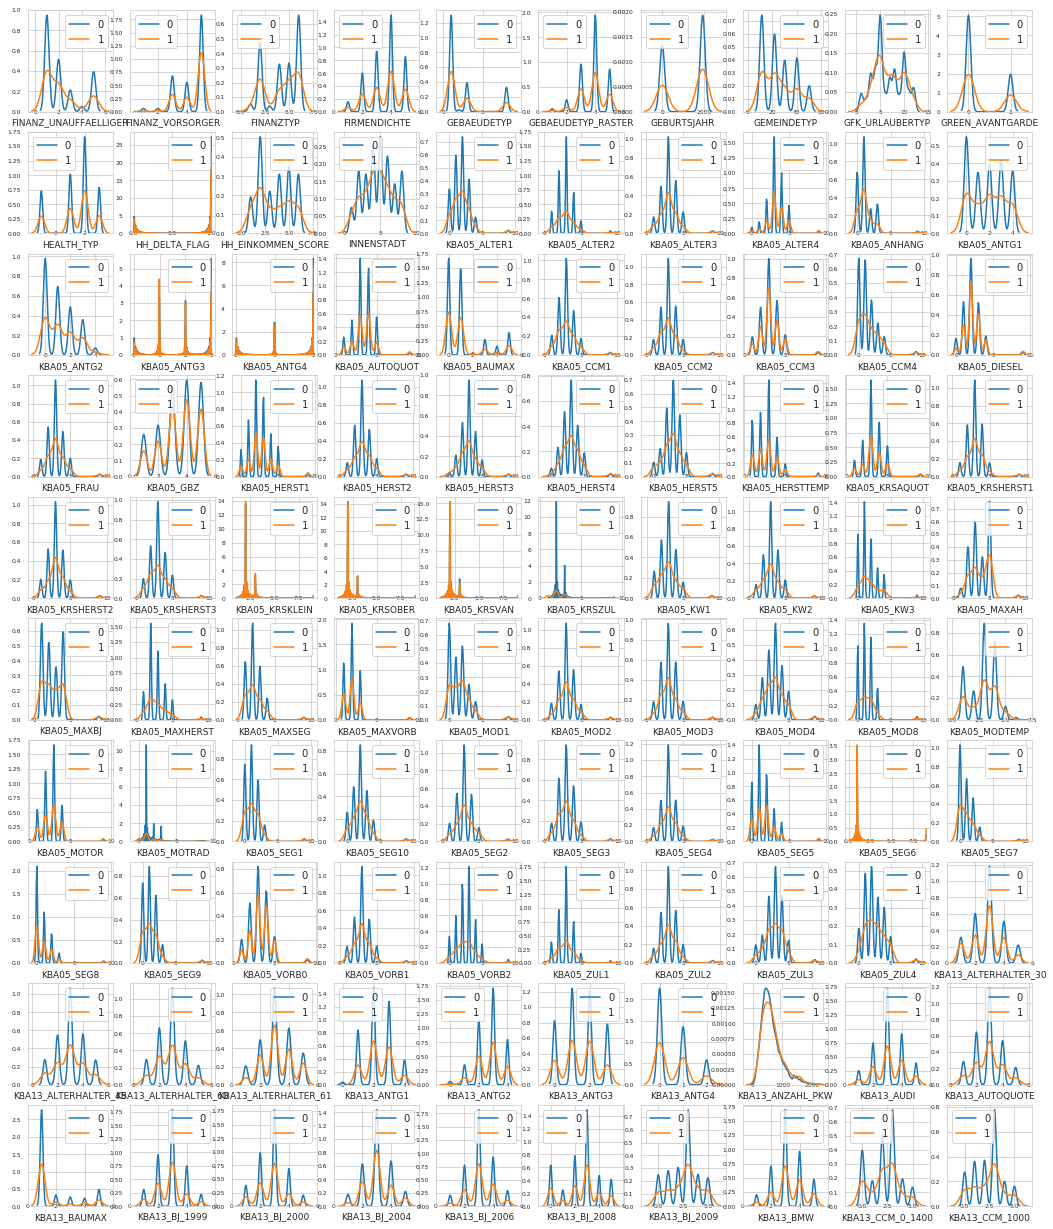

In [90]:
t0 = df_train.loc[df_train['RESPONSE'] == 0]
t1 = df_train.loc[df_train['RESPONSE'] == 1]
features = num_cols[100:200]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

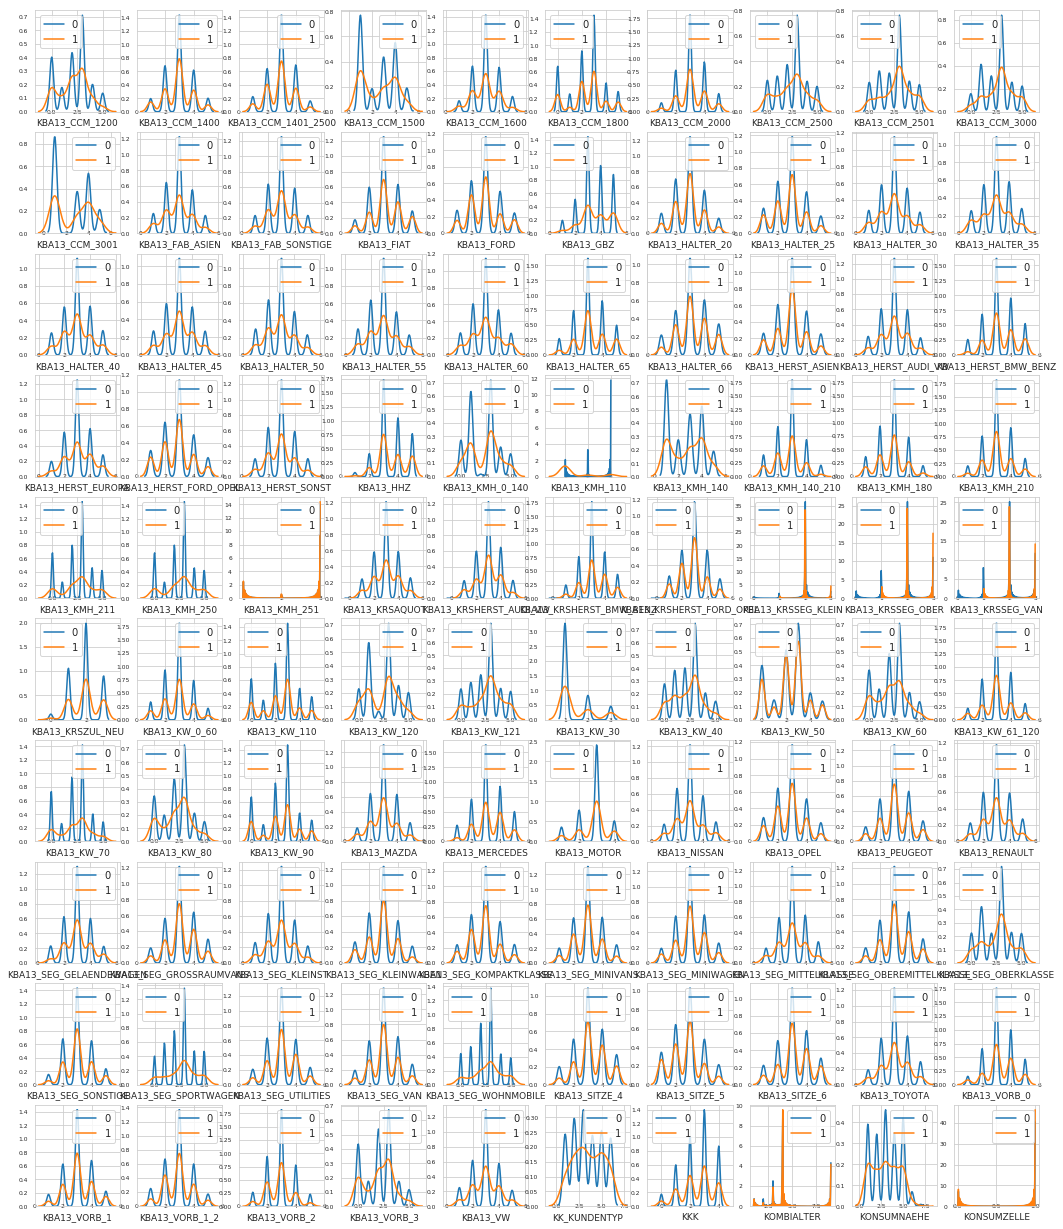

In [91]:
t0 = df_train.loc[df_train['RESPONSE'] == 0]
t1 = df_train.loc[df_train['RESPONSE'] == 1]
features = num_cols[200:300]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

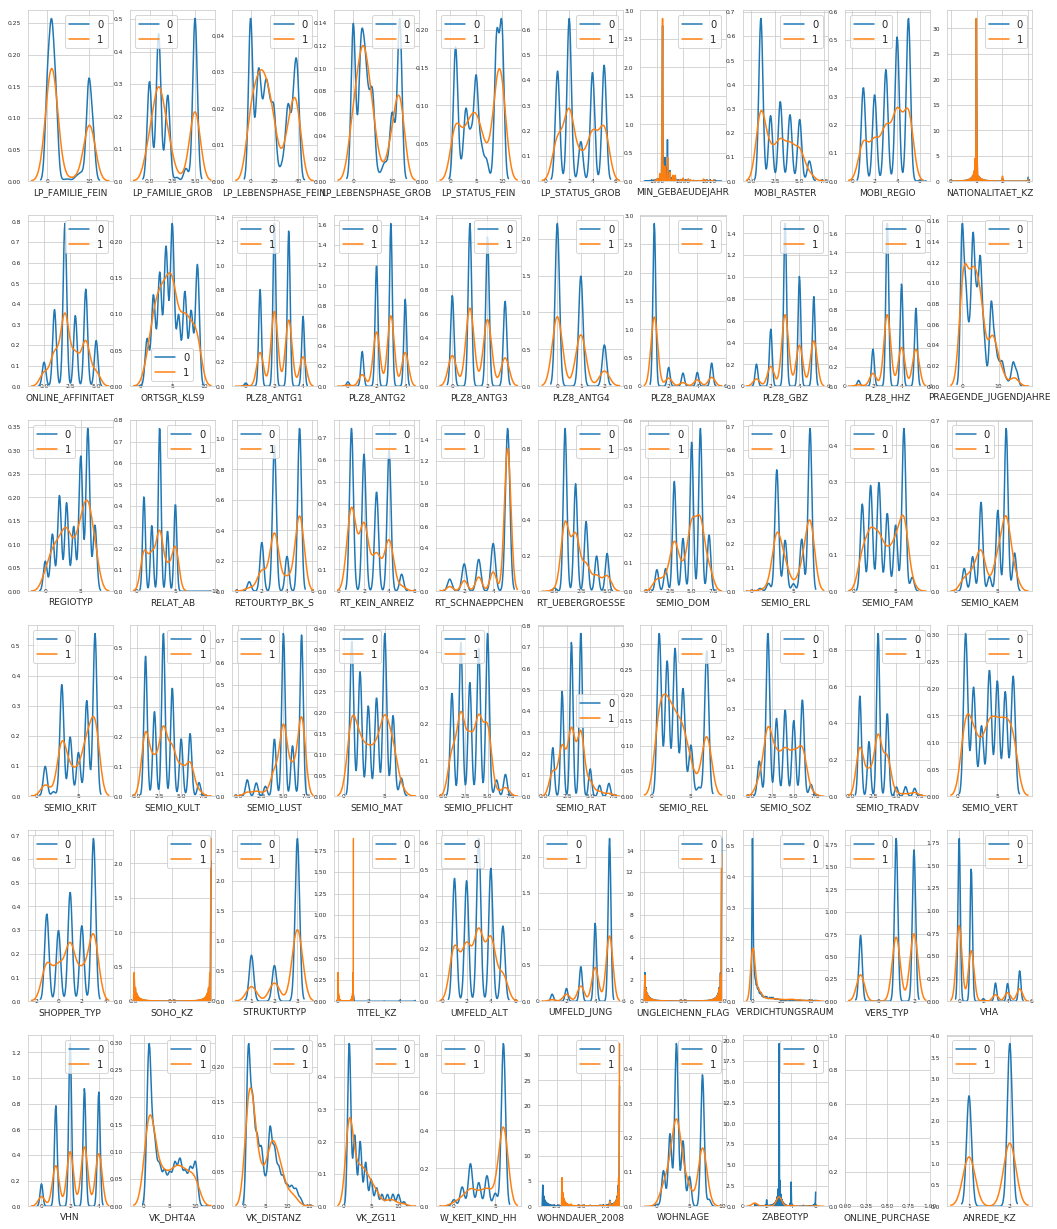

In [108]:
t0 = df_train.loc[df_train['RESPONSE'] == 0]
t1 = df_train.loc[df_train['RESPONSE'] == 1]
features = num_cols[300:360]
plot_feature_distribution(t0, t1, '0', '1', features, col=6)

We already can see that for some features, both have the distribution whereas for some there is a clear difference. These will be closely monitored in the modeling section

Now we move to focus on the distribution between training and testing data. From the plots below, we can see that there is no difference in distribution between the training and testing data.

<Figure size 432x288 with 0 Axes>

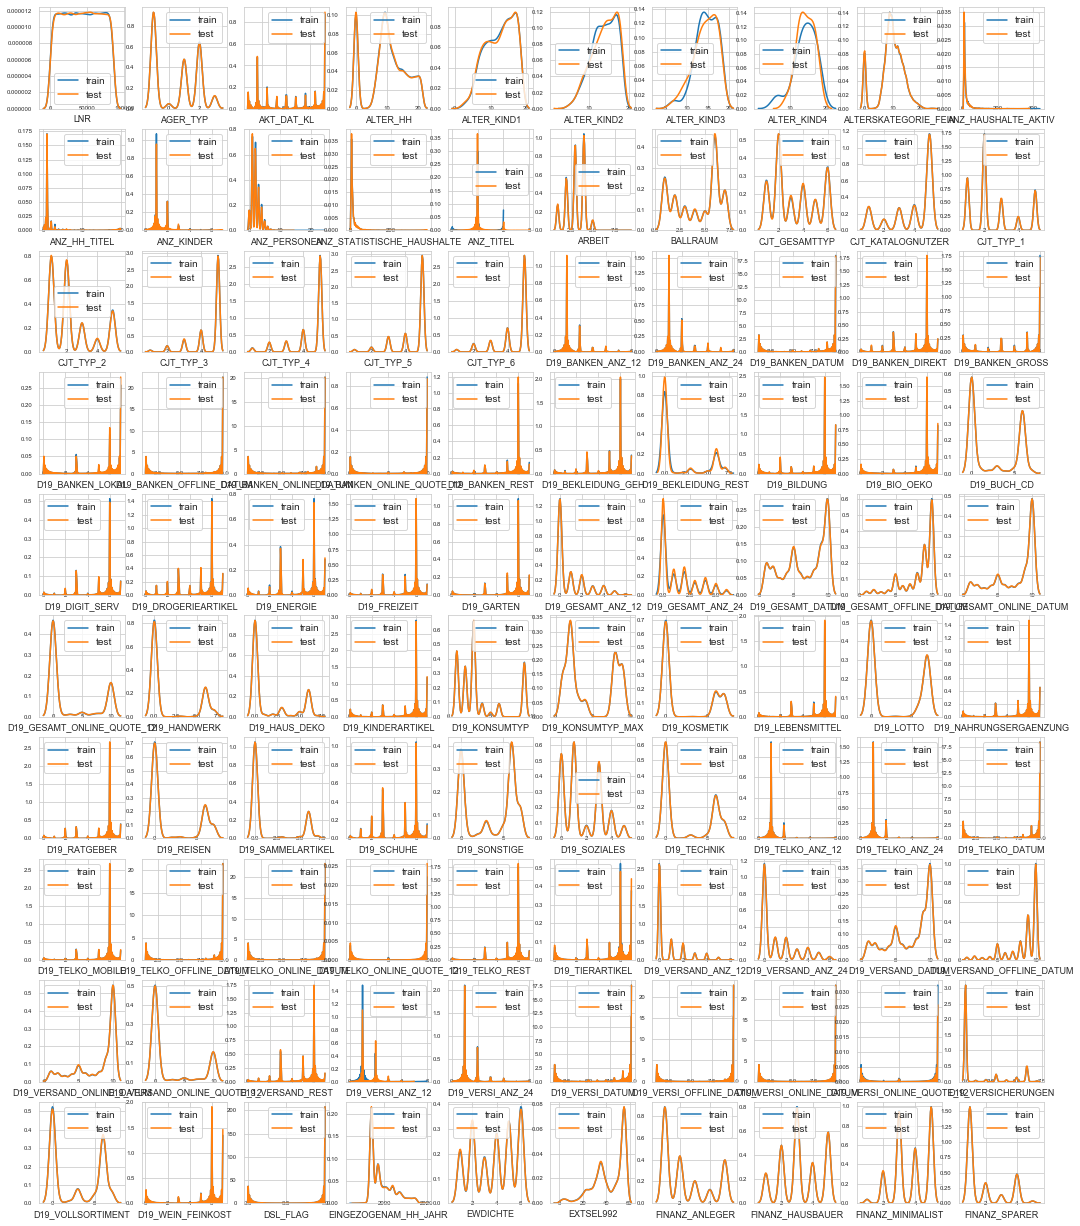

<Figure size 432x288 with 0 Axes>

In [287]:
features = num_cols[:100]
plot_feature_distribution(df_train, df_test, 'train', 'test', features)


<Figure size 432x288 with 0 Axes>

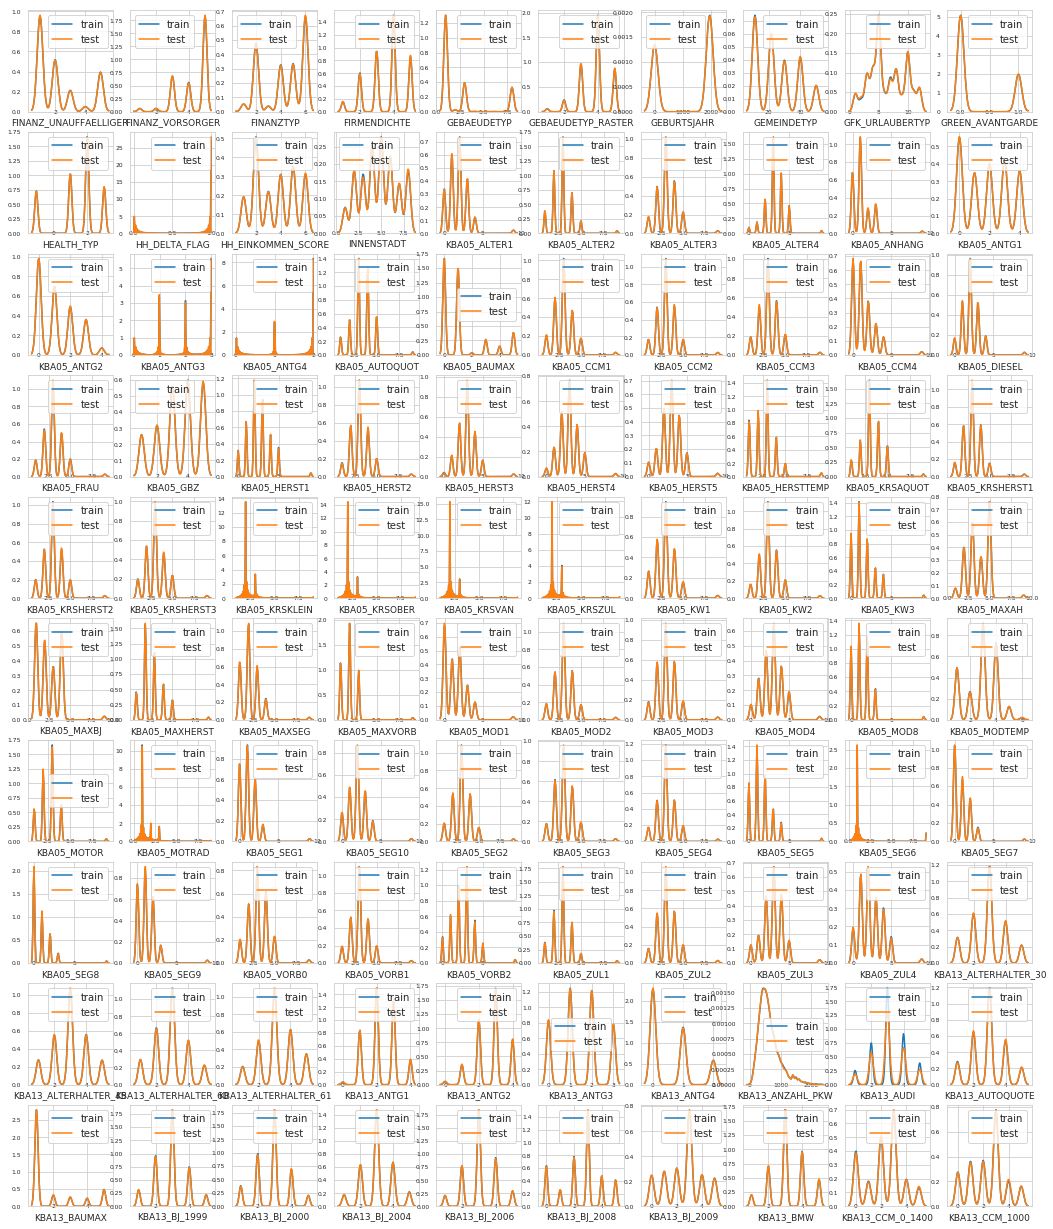

In [96]:
features = num_cols[100:200]
plot_feature_distribution(df_train, df_test, 'train', 'test', features)

<Figure size 432x288 with 0 Axes>

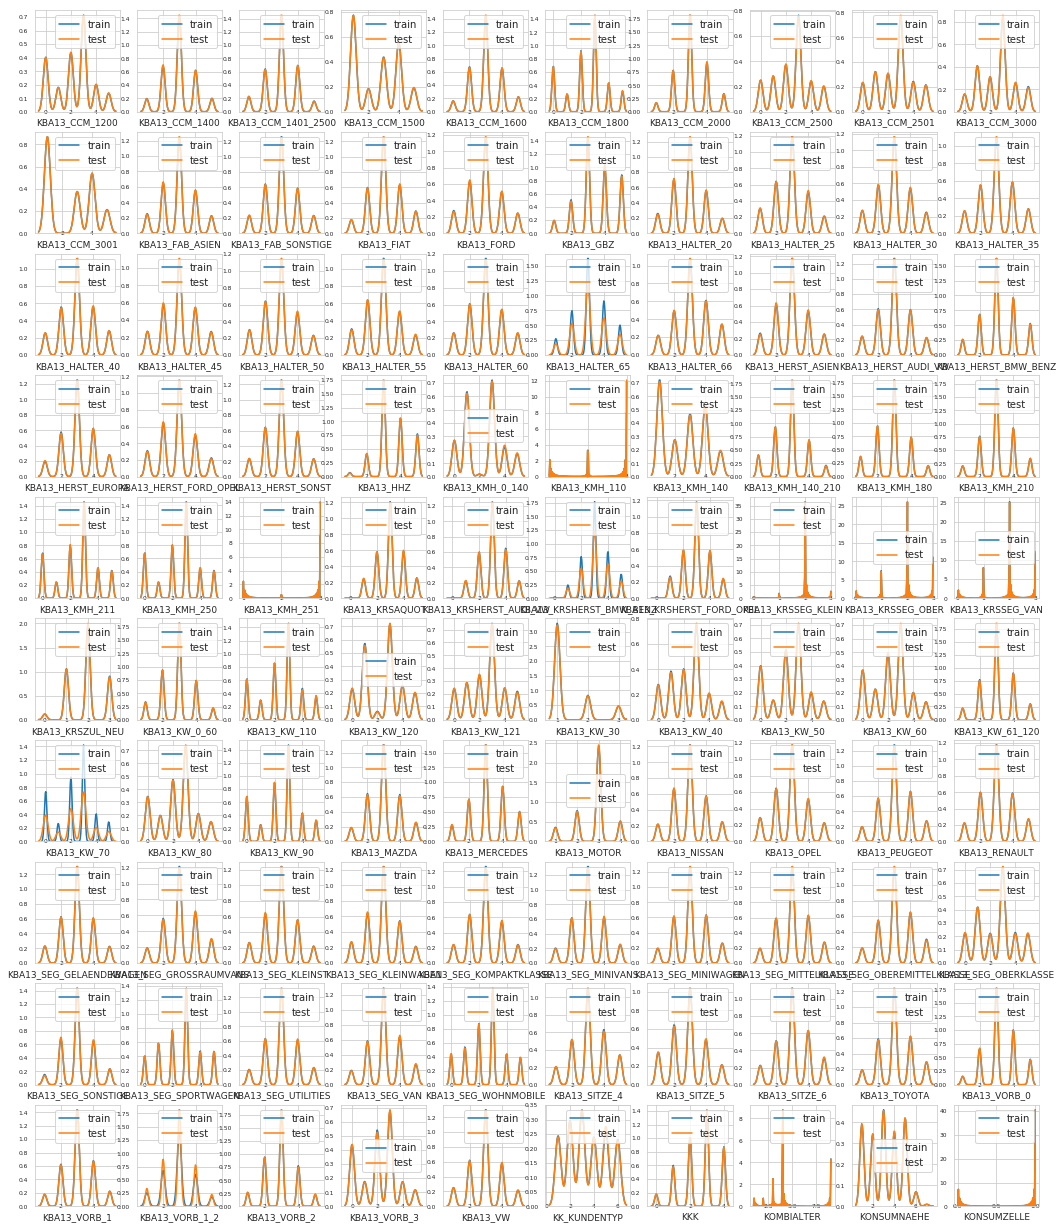

In [97]:
features = num_cols[200:300]
plot_feature_distribution(df_train, df_test, 'train', 'test', features)

# Preprocessing

First we check for duplicates

In [10]:
gen_pop.duplicated().sum()

0

We will utilize the functions from below to replace the specific unkown values for each feature with NaNs to capture the true NaN count in the data.

In [283]:
def replaceMissingWithNaN(col, missing):
    """ A function that returns the number of missing values per column and a list representing the column with missing values converted to NaN
    input:
    col: a Series that contains NaN
    missing: values that are considered NaN for this feature
    Outpu:
    count: number of missing values
    lst: the col with NaN now correctly presented as NaN
    """
    missing.extend(["XX", "X"])
    count = col.isna().sum()
    lst = []
    for item in col:
        if item in missing:
            count += 1
            lst.append(np.NaN)
        else:
            lst.append(item)
    
    return count, lst

def findNans(df, missing):
    """ a function that utilizes replaceMissingWithNaN to provide a DF with all missing values converted to NaN 
    Input:
    df: dataframe to find NaN for
    missing: dataframe with each attribute missing values glossary
    output:
    count_nan: number of NaN per feature
    new_df: the df with now all NaN presented as NaN
    """
    
    headers = df.columns.values

    counts = []
    new_df = pd.DataFrame()
    for i in range(len(df.columns.values)):
        feat = df[headers[i]]
        try:
            miss = list(missing_values.loc[headers[i], :].values) #missing[i]
        except KeyError:
            miss = []
        count , new_df[headers[i]] = replaceMissingWithNaN(feat, miss)
        counts.append([headers[i], count])
    
    count_nan = pd.DataFrame(counts, columns= ['feature', 'NaN_count'])
    
    return count_nan, new_df

def findNansPrep(attributes_values):
    """ A function that prepares a df that contains each attribute with its nan code
    Input: attributes_values: a missing value glossary - dataframe
    Output: dataframe with each attribute missing values glossary
    """
    missing_values = attributes_values[~attributes_values.Attribute.isnull()]
    missing_values.drop(columns=[missing_values.columns[0],'Description'], axis=1,inplace= True)
    missing_values.Meaning.replace({'unknown / no main age detectable': 'unknown'}, inplace= True)
    missing_values = missing_values[missing_values.Meaning == 'unknown']
    missing_values.drop(['Meaning'], axis=1, inplace= True)
    missing_values.set_index('Attribute', inplace= True)
    return missing_values
    
    

We will load the excel file that specify which value does correspond to NaN for each feature

In [284]:
# read xsl file and get values for NaN for each feature
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header= 1)

In [285]:
missing_values = findNansPrep(attributes_values)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Missing data per feature using the functions shown earlier

In [286]:
nan_count, gen_pop_with_nan = findNans(gen_pop, missing_values)

Here we calculate NaN as a percentage for each feature

In [305]:
nan_count['NaN_perc'] = nan_count.NaN_count.apply(lambda x: x/gen_pop_with_nan.shape[0])

We set a limit beyond which the feature is a candidate to be dropped

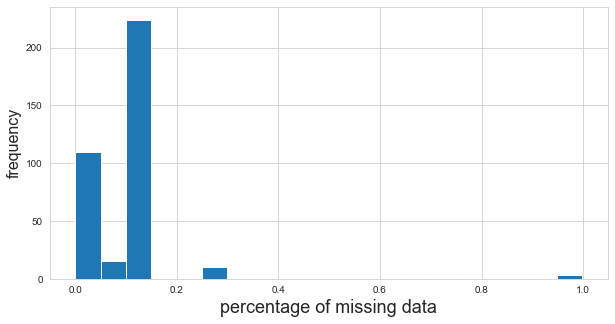

In [309]:
fig, ax = plt.subplots(figsize=[10, 5])
plt.hist(nan_count['NaN_perc'], bins=20);
plt.xlabel('percentage of missing data', fontsize=18)
plt.ylabel('frequency', fontsize=16)
fig.savefig('missing_data_feat_hist.png')

In [310]:
feature_NaN_limit = 0.4

In [311]:
nan_count[nan_count.NaN_perc> feature_NaN_limit]

feature  NaN_count  NaN_perc
2        AGER_TYP     677503  0.760196
5     ALTER_KIND1     810163  0.909048
6     ALTER_KIND2     861722  0.966900
7     ALTER_KIND3     885051  0.993077
8     ALTER_KIND4     890016  0.998648
101     EXTSEL992     654153  0.733996
301  KK_KUNDENTYP     584612  0.655967

AGER_TYP: High correlation with FINANZ_SPARER, but linear regression shows bad fit, DROP <br>
ALTER_HH: No good correlation but relatively lowr NaN percent, KEEP <br>
ALTER_KIND: Good correlation with similar features that have a lot of data missing, DROP <br>
EXTSEL992: Decent correlation with VK_DISTANZ, but linear regression shows bad fit, DROP <br>
KK_KUNDENTYP: Good correlation with D19_GESAMT_DATUM, KEEP




In [15]:
feats = nan_count[nan_count.NaN_perc> feature_NaN_limit].feature
for feat in feats:
    print("\n", feat, "\n", corr.loc[feat, :].nlargest())
    print("\n", corr.loc[feat, :].nsmallest())


 AGER_TYP 
 AGER_TYP            1.000000
FINANZ_VORSORGER    0.581710
CJT_TYP_3           0.394965
CJT_TYP_5           0.384827
CJT_TYP_4           0.375220
Name: AGER_TYP, dtype: float64

 FINANZ_SPARER           -0.611760
FINANZ_ANLEGER          -0.536300
CJT_TYP_1               -0.508349
CJT_TYP_2               -0.505620
FINANZ_UNAUFFAELLIGER   -0.491088
Name: AGER_TYP, dtype: float64

 ALTER_KIND1 
 ALTER_KIND1       1.000000
ALTER_KIND2       0.781195
ALTER_KIND3       0.610869
ALTER_KIND4       0.477439
WOHNDAUER_2008    0.273142
Name: ALTER_KIND1, dtype: float64

 EINGEZOGENAM_HH_JAHR    -0.305786
ANZ_KINDER              -0.259130
CJT_TYP_1               -0.213948
CJT_TYP_2               -0.213663
FINANZ_UNAUFFAELLIGER   -0.209062
Name: ALTER_KIND1, dtype: float64

 ALTER_KIND2 
 ALTER_KIND2         1.000000
ALTER_KIND1         0.781195
ALTER_KIND3         0.774012
ALTER_KIND4         0.645995
FINANZ_VORSORGER    0.216992
Name: ALTER_KIND2, dtype: float64

 EINGEZOGENAM_HH_JAHR

The cell below shows that all the ALTER_KIND data can not be used to imputate the missing values between them 

In [16]:
gen_pop_with_nan[~gen_pop_with_nan.ALTER_KIND1.isnull() | ~gen_pop_with_nan.ALTER_KIND2.isnull() | ~gen_pop_with_nan.ALTER_KIND3.isnull() | ~gen_pop_with_nan.ALTER_KIND4.isnull()].shape[0]/gen_pop_with_nan.shape[0]

0.09095162703751371

In [312]:
def linearRegFillNa(df, feature, util_feature):
    """ A function that utilize linear regression to fill NaN 
    Input:
    df: dataframe to be utilized
    feature: for which linear regression is applied
    util_feature: the feature utilized to extrapolate the wanted feature
    output: 
    predicted_feature: A series that represent the feature after extrapolation
    """
    shared_data_util_feature = df[~df[util_feature].isnull() & ~df[feature].isnull()][util_feature]
    shared_data_util_feature = shared_data_util_feature.values.reshape(-1, 1)
    
    shared_data_feature = df[~df[util_feature].isnull() & ~df[feature].isnull()][feature]
    shared_data_feature = shared_data_feature.values.reshape(-1, 1)
    
    reg = LinearRegression().fit(shared_data_util_feature, shared_data_feature)
    
    available_util_feature = df[~df[util_feature].isnull()][util_feature]
    available_util_feature = available_util_feature.values.reshape(-1, 1)
    
    predicted_feature = reg.predict(available_util_feature)
    predicted_feature = np.round(predicted_feature)
    
    return predicted_feature
    
    
def regFillApply(df, feature, util_feature):
    """ A function that utilize linearRegFillNa to add a new extrapolated feature to df 
    Input:
    df: dataframe to be utilized
    feature: for which linear regression is applied
    util_feature: the feature utilized to extrapolate the wanted feature
    output: 
    None - it changes the df 
    """
    df[feature + "_corr"] = np.nan
    df.loc[~df[util_feature].isnull(), feature + "_corr"] = linearRegFillNa(df, feature, util_feature)
    print("r2=",r2_score(df[~df[util_feature].isnull() & ~df[feature].isnull()][feature], df[~df[util_feature].isnull() & ~df[feature].isnull()][feature + "_corr"]))
    print("MSE=",mean_squared_error(df[~df[util_feature].isnull() & ~df[feature].isnull()][feature], df[~df[util_feature].isnull() & ~df[feature].isnull()][feature + "_corr"]))
    df[feature + "_mod"] = df[feature]
    df[feature + "_mod"].fillna(df[feature + "_corr"], inplace= True)


In [313]:
regFillApply(gen_pop_with_nan, 'AGER_TYP', 'FINANZ_SPARER')

r2= -0.1912770229268712
MSE= 0.6563134597928111


In [314]:
regFillApply(gen_pop_with_nan, 'EXTSEL992', 'VK_DISTANZ')

r2= 0.2794630388402656
MSE= 152.26013553528824


In [315]:
regFillApply(gen_pop_with_nan, 'KK_KUNDENTYP', 'D19_GESAMT_DATUM')

r2= 0.7720671189774412
MSE= 0.6047343685279949


In [21]:
gen_pop_with_nan.columns[-6:].values

array(['AGER_TYP_corr', 'AGER_TYP_mod', 'EXTSEL992_corr', 'EXTSEL992_mod',
       'KK_KUNDENTYP_corr', 'KK_KUNDENTYP_mod'], dtype=object)

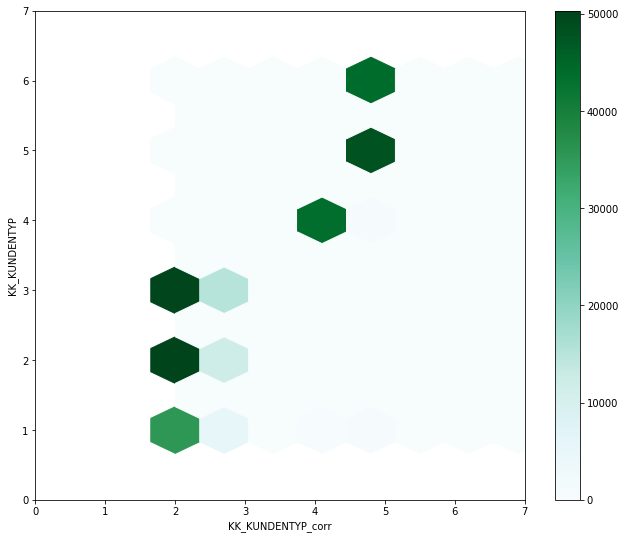

In [22]:
f, ax = plt.subplots(figsize=(11, 9))
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
gen_pop_with_nan.plot.hexbin(x='KK_KUNDENTYP_corr', y='KK_KUNDENTYP', gridsize=10, ax=ax)

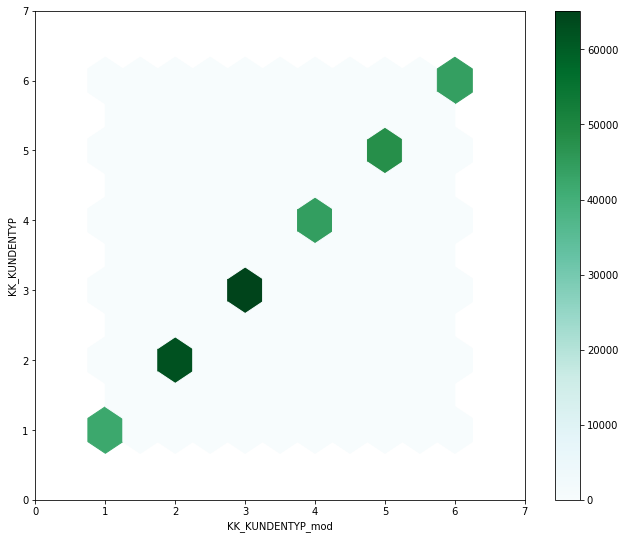

In [23]:
f, ax = plt.subplots(figsize=(11, 9))
plt.xlim(0, 7)
plt.ylim(0, 7)
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()
gen_pop_with_nan.plot.hexbin(x='KK_KUNDENTYP_mod', y='KK_KUNDENTYP', gridsize=10, ax=ax)

In [316]:
gen_pop_with_nan.drop(['AGER_TYP', 'AGER_TYP_corr','AGER_TYP_mod', 'EXTSEL992', 'EXTSEL992_corr', 'EXTSEL992_mod', 'KK_KUNDENTYP', 'KK_KUNDENTYP_corr'], axis=1, inplace=True)

Missing dat per row

In [317]:
# percentage of NaNs per row
gen_pop_with_nan['row_percent_nan']= gen_pop_with_nan.isnull().mean(axis=1) 

(array([7.48851e+05, 2.48000e+03, 2.69860e+04, 7.08800e+03, 2.64200e+03,
        3.93300e+03, 7.00000e+00, 5.81700e+03, 1.51810e+04, 7.82360e+04]),
 array([0.        , 0.07068493, 0.14136986, 0.21205479, 0.28273973,
        0.35342466, 0.42410959, 0.49479452, 0.56547945, 0.63616438,
        0.70684932]),
 <a list of 10 Patch objects>)

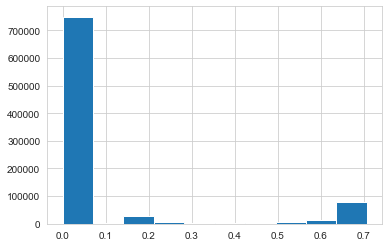

In [318]:
plt.hist(gen_pop_with_nan['row_percent_nan'])

In [319]:
row_NaN_limit = 0.3

In [320]:
gen_pop_low_nan = gen_pop_with_nan[gen_pop_with_nan['row_percent_nan'] < row_NaN_limit]

In [322]:
gen_pop_with_nan.shape[0]-gen_pop_low_nan.shape[0]

105801

In [30]:
gen_pop_low_nan.drop(['row_percent_nan'], axis=1, inplace= True)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [31]:
gen_pop_low_nan[non_numeric_col_gen_pop].head()

OST_WEST_KZ        EINGEFUEGT_AM D19_LETZTER_KAUF_BRANCHE CAMEO_INTL_2015  \
1           W  1992-02-10 00:00:00                      NaN              51   
2           W  1992-02-12 00:00:00            D19_UNBEKANNT              24   
3           W  1997-04-21 00:00:00            D19_UNBEKANNT              12   
4           W  1992-02-12 00:00:00               D19_SCHUHE              43   
5           W  1992-02-12 00:00:00              D19_ENERGIE              54   

  CAMEO_DEU_2015 CAMEO_DEUG_2015  
1             8A               8  
2             4C               4  
3             2A               2  
4             6B               6  
5             8C               8

In [32]:
gen_pop_low_nan['OST_WEST_KZ'].value_counts()

W    619286
O    166134
Name: OST_WEST_KZ, dtype: int64

In [33]:
gen_pop_low_nan.OST_WEST_KZ = gen_pop_low_nan.OST_WEST_KZ.replace({"W": 0, "O": 1}) 

//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [34]:
gen_pop_low_nan['EINGEFUEGT_AM'] = pd.to_datetime(gen_pop_low_nan['EINGEFUEGT_AM'])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
gen_pop_low_nan['EINGEFUEGT_AM_weekday'] = gen_pop_low_nan['EINGEFUEGT_AM'].apply(lambda x: x.weekday())

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [36]:
gen_pop_low_nan['EINGEFUEGT_AM_day'] = gen_pop_low_nan['EINGEFUEGT_AM'].apply(lambda x: x.day)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
gen_pop_low_nan['EINGEFUEGT_AM_month'] = gen_pop_low_nan['EINGEFUEGT_AM'].apply(lambda x: x.month)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
gen_pop_low_nan['EINGEFUEGT_AM_year'] = gen_pop_low_nan['EINGEFUEGT_AM'].apply(lambda x: x.year)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
gen_pop_low_nan.drop(['EINGEFUEGT_AM'], axis= 1, inplace= True)

In [40]:
gen_pop_low_nan['CAMEO_INTL_2015_adj'] = gen_pop_low_nan['CAMEO_INTL_2015'].apply(lambda x: int(x) if x == x else np.nan)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
gen_pop_low_nan['CAMEO_INTL_2015_adj'].value_counts().shape

(21,)

In [42]:
gen_pop_low_nan.drop(['CAMEO_INTL_2015'], axis=1, inplace= True)

In [8]:
def getWealth(col):
    lst = []
    for item in col:
        x = float(item)
        if x > 50:
            lst.append(0)
        elif x > 35:
            lst.append(1)
        elif x > 25:
            lst.append(2)
        elif x > 15:
            lst.append(3)
        elif x > -1:
            lst.append(4)
        else:
            lst.append(np.nan)
    return lst

def getLifeStage(col):
    lst = []
    for item in col:
        if str(item)[1]== '1':
            lst.append(0)
        elif str(item)[1]== '2':
            lst.append(1)
        elif str(item)[1]== '3':
            lst.append(2)
        elif str(item)[1]== '4':
            lst.append(3)
        elif str(item)[1]== '5':
            lst.append(4)
        else:
            lst.append(np.nan)
    return lst


In [44]:
gen_pop_low_nan["wealth"] = getWealth(gen_pop_low_nan["CAMEO_INTL_2015_adj"])

gen_pop_low_nan["life_stage"] = getLifeStage(gen_pop_low_nan['CAMEO_INTL_2015_adj'])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
gen_pop_low_nan.drop(['CAMEO_INTL_2015_adj'], axis= 1, inplace= True)

In [46]:
gen_pop_low_nan['CAMEO_DEUG_2015_adj'] = gen_pop_low_nan['CAMEO_DEUG_2015'].apply(lambda x: int(x) if x == x else np.nan)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [47]:
gen_pop_low_nan['CAMEO_DEUG_2015_adj'].value_counts()

8.0    132942
9.0    106296
6.0    104762
4.0    102620
3.0     85436
2.0     82326
7.0     76817
5.0     54353
1.0     35870
Name: CAMEO_DEUG_2015_adj, dtype: int64

In [48]:
gen_pop_low_nan.drop(['CAMEO_DEUG_2015'], axis= 1, inplace= True)

In [49]:
gen_pop_low_nan['D19_LETZTER_KAUF_BRANCHE'].value_counts()

D19_UNBEKANNT             188143
D19_VERSICHERUNGEN         55659
D19_SONSTIGE               43050
D19_VOLLSORTIMENT          33465
D19_SCHUHE                 31208
D19_BUCH_CD                27738
D19_VERSAND_REST           25062
D19_DROGERIEARTIKEL        23137
D19_BANKEN_DIREKT          22398
D19_BEKLEIDUNG_REST        20890
D19_HAUS_DEKO              20098
D19_TELKO_MOBILE           13904
D19_ENERGIE                11677
D19_TELKO_REST             11064
D19_BANKEN_GROSS           10140
D19_BEKLEIDUNG_GEH          9862
D19_KINDERARTIKEL           6978
D19_FREIZEIT                6966
D19_TECHNIK                 6731
D19_LEBENSMITTEL            6214
D19_BANKEN_REST             5042
D19_RATGEBER                4744
D19_NAHRUNGSERGAENZUNG      3933
D19_DIGIT_SERV              3453
D19_REISEN                  2999
D19_TIERARTIKEL             2480
D19_SAMMELARTIKEL           2349
D19_HANDWERK                2151
D19_WEIN_FEINKOST           2088
D19_GARTEN                  1578
D19_BANKEN

In [50]:
gen_pop_low_nan['CAMEO_DEU_2015'].value_counts()

6B    56079
8A    51918
4C    47265
2D    34718
3C    34379
7A    34003
3D    33972
8B    32849
4A    32657
8C    30754
9D    28090
9B    27288
9C    24577
7B    24134
9A    20394
2C    19192
8D    17421
6E    15970
2B    15302
5D    14692
6C    14648
2A    13114
5A    11878
1D    11845
1A    10722
5B    10242
3A    10093
5C     9780
4B     8938
7C     8900
4D     8493
3B     6992
6A     6709
6D     6018
9E     5947
6F     5338
4E     5267
7D     5199
1E     5009
7E     4581
1C     4266
5F     4237
1B     4028
5E     3524
Name: CAMEO_DEU_2015, dtype: int64

In [51]:
gen_pop_low_nan.shape

(785420, 368)

In [52]:
gc.collect()

80

In [53]:
gen_pop_low_nan_encoded = pd.get_dummies(gen_pop_low_nan, columns = ['D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015'])

More mixed features engineering

wealth:
0 poor: 1,2,5,6,14,15,21,24,29,31
1 mid: 3,4,7,8,16,22,25,30,32
2 rich: 10,13,18,20,23,28,35,39,40

status:
0 single:1-13 and 21-23
1 couple:14-20
2 family: 24-40

age:
0: 1,3,14,18,29,30,33,34,35
1: 2,4,39
2: 5,7,11,37
3: 6, 8,12, 13, 15,16,19,20, 31,32,36,38,40

    

In [9]:
def wealth_soc_stat_age(col):
    """ A function that calculates wealth, social status and age features from LP_LEBENSPHASE_FEIN
    Input:
    col: the original LP_LEBENSPHASE_FEIN col
    Output:
    wealth: wealth feature - Series
    stat: social status feature - Series
    age: age feature - Series
    """
    wealth = []
    stat = []
    age = []
    
    for item in col:
        if item in [1,2,5,6,14,15,21,24,29,31]:
            wealth.append(0)
        elif item in [3,4,7,8,16,22,25,30,32]:
            wealth.append(1)
        elif item in [10,13,18,20,23,28,35,39,40]:
            wealth.append(2)
        else:
            wealth.append(np.nan)
            
    for item in col:
        if item<=13 or 21<=item<=23:
            stat.append(0)
        elif 14<=item<=20:
            stat.append(1)
        elif item>=24:
            stat.append(2)
        else:
            stat.append(np.nan)
            
    for item in col:
        if item in [1,3,14,18,29,30,33,34,35]:
            age.append(0)
        elif item in [2,4,39]:
            age.append(1)
        elif item in [5,7,11,37]:
            age.append(2)
        elif item in [6, 8,12, 13, 15,16,19,20, 31,32,36,38,40]:
            age.append(3)
        else:
            age.append(np.nan)
            
    return wealth, stat, age
    
    

In [10]:
def wealth_soc_stat_LP_LEBENSPHASE_GROB(col):
    """ A function that calculates wealth, social status features from LP_LEBENSPHASE_GROB
    Input:
    col: the original LP_LEBENSPHASE_GROB col
    Output:
    wealth: wealth feature - Series
    stat: social status feature - Series
    """
    wealth = []
    stat = []
    
    for item in col:
        if item in [1,2,4,7,10]:
            wealth.append(0)
        elif item in [9]:
            wealth.append(1)
        elif item in [3,5,8,11,12]:
            wealth.append(2)
        else:
            wealth.append(np.nan)
            
    for item in col:
        if item <=7:
            stat.append(0)
        elif item > 7:
            stat.append(1)
        else:
            stat.append(np.nan)
        
    return wealth, stat

In [56]:
gen_pop_low_nan_encoded['LP_LEBENSPHASE_FEIN_wealth'], gen_pop_low_nan_encoded['LP_LEBENSPHASE_FEIN_stat'], gen_pop_low_nan_encoded['LP_LEBENSPHASE_FEIN_age'] = wealth_soc_stat_age(gen_pop_low_nan_encoded.LP_LEBENSPHASE_FEIN)

In [57]:
gen_pop_low_nan_encoded['LP_LEBENSPHASE_GROB_wealth'], gen_pop_low_nan_encoded['LP_LEBENSPHASE_GROB_stat'] = wealth_soc_stat_LP_LEBENSPHASE_GROB(gen_pop_low_nan_encoded.LP_LEBENSPHASE_GROB)

In [11]:

def getDecade(col):
    """ a function that calculated the decade of a person's youth movement from PRAEGENDE_JUGENDJAHRE
    Input:
    col: PRAEGENDE_JUGENDJAHRE
    output: 
    lst: the decade of a person's youth movement - list
    """
    lst = []
    for item in col:
        if item==1 or item==2:
            lst.append(1)
        elif item==3 or item==4:
            lst.append(2)
        elif item>4 and item<8:
            lst.append(3)
        elif item==8 or item==9:
            lst.append(4)
        elif item>9 and item<14:
            lst.append(5)
        elif item==14 or item==15:
            lst.append(6)
        else:
            lst.append(np.nan)
    
    return lst

def getMovement(col):
    """ a function that calculates the movement of interest during a person's youth from  PRAEGENDE_JUGENDJAHRE
    input:
    col: PRAEGENDE_JUGENDJAHRE
    output:
    lst: the movement of interest during a person's youth - list
    """
    lst = []
    for item in col:
        if item in [1, 3, 5, 8, 10, 12, 14]:
            lst.append(0)
        elif item in [2, 4, 6, 7, 9, 11, 13, 15]:
            lst.append(1)
        else:
            lst.append(np.nan)
    
    return lst

In [59]:
gen_pop_low_nan_encoded['Movement'] = getMovement(gen_pop_low_nan_encoded['PRAEGENDE_JUGENDJAHRE'])
gen_pop_low_nan_encoded['Decade']= getDecade(gen_pop_low_nan_encoded['PRAEGENDE_JUGENDJAHRE'])

In [60]:
gen_pop_low_nan_encoded['WOHNLAGE_adj'] = gen_pop_low_nan_encoded.WOHNLAGE.apply(lambda x: x if x < 7 else np.nan)

In [61]:
gen_pop_low_nan_encoded.drop(['WOHNLAGE'], axis= 1, inplace= True)

In [62]:
gen_pop_low_nan_encoded['PLZ8_BAUMAX_adj'] = gen_pop_low_nan_encoded.PLZ8_BAUMAX.apply(lambda x: x if x < 5 else np.nan)

In [63]:
gen_pop_low_nan_encoded.drop(['PLZ8_BAUMAX'], axis= 1, inplace= True)

In [65]:
gen_pop_low_nan_encoded.drop(["ALTER_KIND1","ALTER_KIND2","ALTER_KIND3","ALTER_KIND4"], axis= 1, inplace= True)

In [66]:
gen_pop_low_nan_encoded.shape

(785420, 448)

In [67]:
gc.collect()

74

In [73]:
# gen_pop_low_nan_encoded.to_csv('gen_pop_low_nan_encoded_mixed_resolved_pending_eng.csv')

In [71]:
del gen_pop, gen_pop_low_nan, gen_pop_with_nan

In [72]:
gc.collect()

7707

In [73]:
idx = gen_pop_low_nan_encoded.columns.values[1:]
for df in [gen_pop_low_nan_encoded]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

In [328]:
gen_pop_low_nan_encoded.drop(columns=['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE'], axis= 1, inplace= True)

In [324]:
gen_pop_low_nan_encoded.head()

LNR  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
1  910220         9.0       NaN                  21.0                 11.0   
2  910225         9.0      17.0                  17.0                 10.0   
3  910226         1.0      13.0                  13.0                  1.0   
4  910241         1.0      20.0                  14.0                  3.0   
5  910244         1.0      10.0                  10.0                  5.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
1           0.0         0.0           2.0                        12.0   
2           0.0         0.0           1.0                         7.0   
3           0.0         0.0           0.0                         2.0   
4           0.0         0.0           4.0                         3.0   
5           0.0         0.0           1.0                         2.0   

   ANZ_TITEL  ...  WOHNLAGE_adj  PLZ8_BAUMAX_adj      sum  min     max  \
1        0.0  ...           4.0              1.0  10009.0  0.0  2004.0   
2        0.0  ...           2.0              1.0   9757.0  0.0  2000.0   
3        0.0  ...           NaN              1.0   9607.0  0.0  1998.0   
4        0.0  ...           3.0              2.0   9528.0  0.0  2004.0   
5        0.0  ...           NaN              1.0  10255.0  0.0  1994.0   

        mean         std       skew        kurt  med  
1  22.956422  195.586616   9.738685   94.776432  2.0  
2  21.827740  190.308528  10.083373  101.529590  2.0  
3  21.784580  190.400287  10.109462  101.864963  2.0  
4  21.315436  188.208420  10.299981  105.396267  2.0  
5  22.993274  196.303050   9.573262   91.164293  2.0  

[5 rows x 453 columns]

Now we start the imputation, scaling process and PCA to start the segmentation process

In [329]:
imp = SimpleImputer(missing_values= np.nan, strategy='mean')
gen_pop_no_nan = imp.fit_transform(gen_pop_low_nan_encoded)
scaler = RobustScaler()
gen_pop_no_nan_scaled = scaler.fit_transform(gen_pop_no_nan)

In [330]:
pca = PCA()
X_pca = pca.fit_transform(gen_pop_no_nan_scaled)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

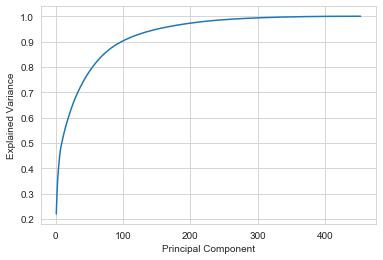

In [331]:
n = len(pca.explained_variance_ratio_)
vr = pca.explained_variance_ratio_
index = np.arange(1, n + 1)
cum_vr = np.cumsum(vr)
    
plt.figure()
ax = plt.subplot()
ax.plot(index, cum_vr)
    
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance")
plt.savefig('pca_vr.png')

In [332]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(gen_pop_no_nan_scaled)

In [333]:
pca.explained_variance_ratio_.sum()

0.9021340710151671

In [334]:
def getWeight(pca, component, df, abs):
    """ A function that calculates the weights of features for each component of pca
    input:
    pca: pca of interest
    component: the number for the component we're interested in investigating - int
    df: the dataframe utilized
    abs: a flag to get the absolute value or not - bool
    
    """
    weights = {}
    index_for_weights = df.columns
    for i in range(pca.components_.shape[1]):
        if abs:
            weights[index_for_weights[i]] = abs(pca.components_[component-1][i])
        else:
            weights[index_for_weights[i]] = pca.components_[component-1][i]

    sort_weights = sorted(weights.items(), key= operator.itemgetter(1))
    return sort_weights

In [335]:
getWeight(pca, 1, gen_pop_low_nan_encoded, False)

[('D19_HAUS_DEKO', -0.01204506005626526),
 ('D19_BEKLEIDUNG_REST', -0.011891248251020819),
 ('Movement', -0.011179026544513056),
 ('D19_KOSMETIK', -0.01104645772364246),
 ('D19_REISEN', -0.010847353880778987),
 ('D19_KINDERARTIKEL', -0.010467096718028583),
 ('KBA05_GBZ', -0.0104492471407466),
 ('D19_TELKO_MOBILE', -0.010352336613163985),
 ('MOBI_REGIO', -0.010213617669301518),
 ('D19_HANDWERK', -0.010038447468377438),
 ('D19_BANKEN_DIREKT', -0.00928839882910659),
 ('ANZ_PERSONEN', -0.008879275049852624),
 ('D19_VERSAND_REST', -0.008740906796710458),
 ('D19_TELKO_REST', -0.007903415872586654),
 ('D19_DROGERIEARTIKEL', -0.007689170910953993),
 ('D19_SAMMELARTIKEL', -0.007320965851109183),
 ('D19_VERSAND_ANZ_12', -0.007219100444147071),
 ('D19_FREIZEIT', -0.007165606878100319),
 ('D19_GESAMT_ANZ_24', -0.006934704513188864),
 ('KBA13_AUTOQUOTE', -0.006763741384525784),
 ('MOBI_RASTER', -0.006630832878307195),
 ('D19_BEKLEIDUNG_GEH', -0.006262964450059099),
 ('GEBAEUDETYP_RASTER', -0.006244

status from car ownership

In [336]:
getWeight(pca, 2, gen_pop_low_nan_encoded, False)

[('D19_GESAMT_OFFLINE_DATUM', -0.15800334965636664),
 ('D19_BANKEN_DATUM', -0.14795788607080707),
 ('D19_VERSI_DATUM', -0.13622028210365306),
 ('D19_VERSAND_OFFLINE_DATUM', -0.1244457299988457),
 ('D19_BANKEN_ONLINE_DATUM', -0.12112178222343817),
 ('PLZ8_BAUMAX_adj', -0.09248974768460314),
 ('D19_TELKO_DATUM', -0.08704368001866987),
 ('ANZ_STATISTISCHE_HAUSHALTE', -0.08537222643825047),
 ('ANZ_HAUSHALTE_AKTIV', -0.08444843861124689),
 ('ZABEOTYP', -0.0779019696380158),
 ('KBA13_ANTG3', -0.07394443703529278),
 ('PLZ8_ANTG3', -0.06938942167422846),
 ('VK_DISTANZ', -0.06658224791702685),
 ('D19_GESAMT_ONLINE_DATUM', -0.06650003221369383),
 ('D19_VERSAND_DATUM', -0.0656242087162267),
 ('VK_DHT4A', -0.06229977884413125),
 ('KK_KUNDENTYP_mod', -0.0620479981758014),
 ('D19_VERSAND_ONLINE_DATUM', -0.06145013812426142),
 ('D19_GESAMT_DATUM', -0.060313022113151045),
 ('VK_ZG11', -0.05573717301218422),
 ('FINANZ_HAUSBAUER', -0.05545501098111772),
 ('D19_KONSUMTYP_MAX', -0.05436051491805552),
 ('K

level of recent activity

In [337]:
getWeight(pca, 3, gen_pop_low_nan_encoded, False)

[('D19_BANKEN_ONLINE_QUOTE_12', -0.1360572543662393),
 ('D19_KOSMETIK', -0.12468960562247824),
 ('D19_REISEN', -0.1146501132233671),
 ('D19_HAUS_DEKO', -0.11348543263775318),
 ('D19_BEKLEIDUNG_REST', -0.11299415342441017),
 ('D19_TELKO_MOBILE', -0.10614623984260145),
 ('D19_HANDWERK', -0.09994121473242457),
 ('D19_BANKEN_DIREKT', -0.09795742995893847),
 ('D19_KINDERARTIKEL', -0.09325664758870172),
 ('D19_VERSAND_REST', -0.08744040749514585),
 ('D19_SAMMELARTIKEL', -0.08424261904170294),
 ('D19_DROGERIEARTIKEL', -0.0789570915954452),
 ('D19_TELKO_REST', -0.0765791763385359),
 ('D19_FREIZEIT', -0.07054663548973765),
 ('D19_RATGEBER', -0.06746193080413145),
 ('D19_VERSAND_ANZ_12', -0.06460556868490057),
 ('D19_BILDUNG', -0.06358583632808822),
 ('D19_BANKEN_GROSS', -0.06187478548087799),
 ('ANZ_PERSONEN', -0.06150098606879085),
 ('D19_GESAMT_ANZ_24', -0.06022736356688617),
 ('Movement', -0.05944472029332886),
 ('D19_WEIN_FEINKOST', -0.059433105327462),
 ('D19_BEKLEIDUNG_GEH', -0.0590935686

offline activity

In [ ]:
score = []
for i in range(2,50):
    kmean_init = KMeans(n_clusters=i, random_state=42)
    model = kmean_init.fit(X_pca)
    score.append(abs(model.score(X_pca)))
    print("\nDone with i:",i,"The score is:",score[i-2])
    
plt.plot(list(range(2,50)), score)
plt.xlabel('K')
plt.ylabel('SSE')


Done with i: 2 The score is: 322575926.1651047

Done with i: 3 The score is: 313364868.9455074

Done with i: 4 The score is: 294083124.38877946

Done with i: 5 The score is: 289608968.5943805

Done with i: 6 The score is: 285799198.03568727

Done with i: 7 The score is: 282779062.51599026

Done with i: 8 The score is: 280271214.7924869

Done with i: 9 The score is: 278013506.2584997

Done with i: 10 The score is: 276143756.39900583

Done with i: 11 The score is: 274601071.3823531

Done with i: 12 The score is: 273162607.5241778

Done with i: 13 The score is: 271971142.77329594

Done with i: 14 The score is: 270958796.31468433

Done with i: 15 The score is: 270032405.01610416

Done with i: 16 The score is: 269158948.1825118

Done with i: 17 The score is: 267972887.09040833

Done with i: 18 The score is: 267136341.61606655

Done with i: 19 The score is: 266698935.31224236

Done with i: 20 The score is: 266108016.88404578

Done with i: 21 The score is: 265039423.27700454

Done with i: 22

In [2]:
t= """Done with i: 2 The score is: 322575926.1651047

Done with i: 3 The score is: 313364868.9455074

Done with i: 4 The score is: 294083124.38877946

Done with i: 5 The score is: 289608968.5943805

Done with i: 6 The score is: 285799198.03568727

Done with i: 7 The score is: 282779062.51599026

Done with i: 8 The score is: 280271214.7924869

Done with i: 9 The score is: 278013506.2584997

Done with i: 10 The score is: 276143756.39900583

Done with i: 11 The score is: 274601071.3823531

Done with i: 12 The score is: 273162607.5241778

Done with i: 13 The score is: 271971142.77329594

Done with i: 14 The score is: 270958796.31468433

Done with i: 15 The score is: 270032405.01610416

Done with i: 16 The score is: 269158948.1825118

Done with i: 17 The score is: 267972887.09040833

Done with i: 18 The score is: 267136341.61606655

Done with i: 19 The score is: 266698935.31224236

Done with i: 20 The score is: 266108016.88404578

Done with i: 21 The score is: 265039423.27700454

Done with i: 22 The score is: 264688265.60141635

Done with i: 23 The score is: 264051640.00621733

Done with i: 24 The score is: 262881819.14802387

Done with i: 25 The score is: 262337590.6471799

Done with i: 26 The score is: 262184419.8864755

Done with i: 27 The score is: 261115804.98523906

Done with i: 28 The score is: 260998236.72914648

Done with i: 29 The score is: 260057365.04721287

Done with i: 30 The score is: 259490030.89395157

Done with i: 31 The score is: 258799883.74145913

Done with i: 32 The score is: 258565547.29967064

Done with i: 33 The score is: 258335945.05115688"""

In [6]:
score = re.findall("\d+\.\d+", t)

Text(0, 0.5, 'SSE')

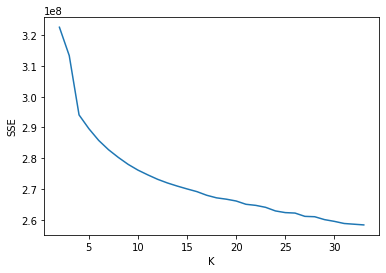

In [26]:
plt.plot(list(range(2,34)), [float(val) for val in score])
plt.xlabel('K')
plt.ylabel('SSE')

In [17]:
k = 10

In [18]:
kmeans = KMeans(n_clusters= k, random_state=42)
final_model = kmeans.fit(X_pca)

In [19]:
gen_population_predict = final_model.predict(X_pca)

In [206]:
def clean_data(df, no_del=True):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, no_del: flag to cancel row elimination
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # Get rid of Unnamed 0 col
    if 'Unnamed: 0' in df.columns:
        df.drop(['Unnamed: 0'], axis=1, inplace= True)
    
    # convert missing value codes into NaNs, ...
    print("initial", df.shape)
    _, df = findNans(df, missing_values)
    print("after findNans", df.shape)
    
    # extrapolate high NaN but high correlation features
    regFillApply(df, 'KK_KUNDENTYP', 'D19_GESAMT_DATUM')
    
    # remove selected columns and rows, ...
    to_be_removed = ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'EXTSEL992', 'KK_KUNDENTYP', 'KK_KUNDENTYP_corr']
    
    df.drop(to_be_removed, axis=1, inplace=True)
    
    if no_del:
        df['percent_NaN'] = df.isnull().mean(axis=1) 
        df = df.loc[df['percent_NaN'] <= 0.3, :]
        print("after removing some rows", df.shape)
        df.drop(['percent_NaN'], axis=1, inplace=True)
        print("after removing percent_NaN", df.shape)

    
    # select, re-encode, and engineer column values.
    try:
        df.OST_WEST_KZ.replace({"W": 0, "O": 1}, inplace=True)
    except:
        pass
    
    print("after OST_WEST_KZ", df.shape)
    
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
    df['EINGEFUEGT_AM_weekday'] = df['EINGEFUEGT_AM'].apply(lambda x: x.weekday())
    df['EINGEFUEGT_AM_day'] = df['EINGEFUEGT_AM'].apply(lambda x: x.day)
    df['EINGEFUEGT_AM_month'] = df['EINGEFUEGT_AM'].apply(lambda x: x.month)
    df['EINGEFUEGT_AM_year'] = df['EINGEFUEGT_AM'].apply(lambda x: x.year)
    
    print("after engineering EINGEFUEGT Features")
    
    df['CAMEO_INTL_2015_adj'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x) if x == x else np.nan)
    if 'CAMEO_INTL_2015_adj' in df.columns:    
        df["wealth"] = getWealth(df["CAMEO_INTL_2015"])
        df["life_stage"] = getLifeStage(df['CAMEO_INTL_2015'])  
    
    print("after engineering wealth, life_stage")
    
    df['CAMEO_DEUG_2015_adj'] = df['CAMEO_DEUG_2015'].apply(lambda x: int(x) if x == x else np.nan)

    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['Movement'] = getMovement(df['PRAEGENDE_JUGENDJAHRE'])
        df['Decade']= getDecade(df['PRAEGENDE_JUGENDJAHRE'])
        
    print("after engineering Movement and Decade")
    
    df['LP_LEBENSPHASE_FEIN_wealth'], df['LP_LEBENSPHASE_FEIN_stat'], df['LP_LEBENSPHASE_FEIN_age'] = wealth_soc_stat_age(df.LP_LEBENSPHASE_FEIN)
    df['LP_LEBENSPHASE_GROB_wealth'], df['LP_LEBENSPHASE_GROB_stat'] = wealth_soc_stat_LP_LEBENSPHASE_GROB(df.LP_LEBENSPHASE_GROB)    
    
    print("after engineering FEIN_wealth,stat,age and GROB_wealth,stat")
    
    df['WOHNLAGE_adj'] = df.WOHNLAGE.apply(lambda x: x if x < 7 else np.nan)
    df['PLZ8_BAUMAX_adj'] = df.PLZ8_BAUMAX.apply(lambda x: x if x < 5 else np.nan)
    
    df.drop(['EINGEFUEGT_AM','CAMEO_INTL_2015', 'CAMEO_INTL_2015_adj','CAMEO_DEUG_2015', 'PRAEGENDE_JUGENDJAHRE','LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'], axis= 1, inplace= True)

        
                
    print("before hot encoding", df.shape)
    df = pd.get_dummies(df, columns = ['D19_LETZTER_KAUF_BRANCHE','CAMEO_DEU_2015'])
    print("after hot encoding", df.shape)
    
    idx = df.columns.values[1:]
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)
    
    print("after engineering sum, min, max, etc features")

    return df

In [21]:
customers_processed = clean_data(customers)

initial (191652, 369)
after findNans (191652, 369)
r2= 0.6909194026562073
MSE= 0.8150410838612557
after removing some rows (140371, 364)
after removing percent_NaN (140371, 363)
after OST_WEST_KZ (140371, 363)
after engineering EINGEFUEGT Features
after engineering wealth, life_stage
after engineering Movement and Decade
after engineering FEIN_wealth,stat,age and GROB_wealth,stat
before hot encoding (140371, 371)
after hot encoding (140371, 448)
after engineering sum, min, max, etc features


In [22]:
customers_processed.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis= 1, inplace= True)

In [143]:
customers_imp = imp.transform(customers_processed)
customers_scaled = scaler.transform(customers_imp)
customers_pca = pca.transform(customers_scaled)
customers_clusters = final_model.predict(customers_pca)

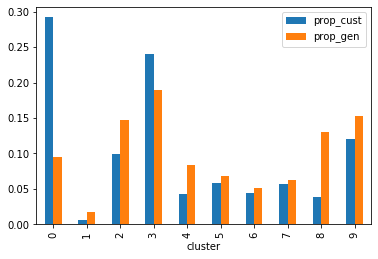

In [24]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
prop_gen_pop = []
prop_cust_pop = []

counts = np.unique(customers_clusters, return_counts=True)[1]
for i in range(10):
    prop_cust_pop.append(counts[i]/len(customers_clusters))
    
counts = np.unique(gen_population_predict, return_counts=True)[1]
for i in range(10):
    prop_gen_pop.append(counts[i]/len(gen_population_predict))
    
temp_df = {'cluster': list(range(10)), 'prop_cust': prop_cust_pop, 'prop_gen': prop_gen_pop}    
prop_df = pd.DataFrame(temp_df)


prop_df.plot(x='cluster', y = ['prop_cust', 'prop_gen'], kind='bar')

In [25]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
over_rep_inv_pca = pca.inverse_transform(customers_pca[np.where(customers_clusters==0)])
over_rep = scaler.inverse_transform(over_rep_inv_pca).round()
over_rep_df = pd.DataFrame(data= over_rep, columns=customers_processed.columns)
over_rep_df = over_rep_df.applymap(lambda x: x if x>0 else 0)

over_rep_df.mean().sort_values()

gen_pop_clust_inv_pca = pca.inverse_transform(X_pca[np.where(gen_population_predict!=0)])
gen_pop_clust = scaler.inverse_transform(gen_pop_clust_inv_pca).round()
gen_pop_clust_df = pd.DataFrame(data= gen_pop_clust, columns=customers_processed.columns)
gen_pop_clust_df = gen_pop_clust_df.applymap(lambda x: x if x>0 else 0)

In [31]:
sort_diff = (over_rep_df.mean() - gen_pop_clust_df.mean()).sort_values()

In [32]:
sort_diff

LNR                           -27167.570079
max                               -7.961723
ANZ_HAUSHALTE_AKTIV               -6.369678
EINGEZOGENAM_HH_JAHR              -6.101864
ANZ_STATISTISCHE_HAUSHALTE        -5.721677
kurt                              -5.118226
VK_DISTANZ                        -4.881716
VK_ZG11                           -4.413949
D19_VERSAND_DATUM                 -3.793515
D19_KONSUMTYP_MAX                 -3.764235
D19_GESAMT_DATUM                  -3.615585
VK_DHT4A                          -3.429383
AKT_DAT_KL                        -3.414888
KK_KUNDENTYP_mod                  -3.107894
D19_VERSAND_ONLINE_DATUM          -3.018667
CAMEO_DEU_2015_9D                 -2.906263
D19_GESAMT_ONLINE_DATUM           -2.849660
D19_GESAMT_OFFLINE_DATUM          -2.815990
D19_KONSUMTYP                     -2.695517
ALTERSKATEGORIE_FEIN              -2.603328
D19_VERSAND_OFFLINE_DATUM         -2.550996
CAMEO_DEUG_2015_adj               -2.066631
GFK_URLAUBERTYP                 

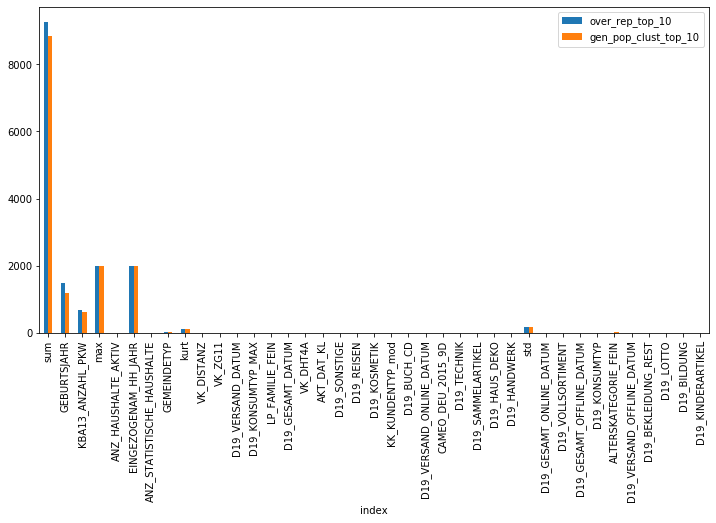

In [86]:
ind = np.abs(sort_diff).sort_values(ascending=False)[1:40].index
over_rep_top_10 = over_rep_df[ind].mean().round()
gen_pop_clust_top_10 = gen_pop_clust_df[ind].mean().round()
compare_dict = {'index': list(ind), 'over_rep_top_10': over_rep_top_10, 'gen_pop_clust_top_10': gen_pop_clust_top_10}
compare_df = pd.DataFrame(compare_dict)
compare_df.plot(x='index', y = ['over_rep_top_10', 'gen_pop_clust_top_10'], kind='bar',figsize=(12,6))

In [35]:
over_rep_df.ANZ_HAUSHALTE_AKTIV.mean()

2.518459774041629

In [36]:
gen_pop_clust_df.ANZ_HAUSHALTE_AKTIV.mean()

8.888137449189852

In [37]:
gen_pop_clust_df.ANZ_HAUSHALTE_AKTIV.mean()-over_rep_df.ANZ_HAUSHALTE_AKTIV.mean()

6.369677675148223

In [74]:
new_df = pd.concat([gen_pop_clust_df.mean(), over_rep_df.mean()], axis= 1)

In [75]:
new_df_2 = new_df.applymap(lambda x: x if x != 0 else x+0.001)

In [64]:
(0.003489-0.189585)/0.189585

-0.9815966453042172

In [63]:
new_df.loc['CAMEO_DEU_2015_9B',:]

0    0.189585
1    0.003489
Name: CAMEO_DEU_2015_9B, dtype: float64

In [76]:
sort_diff2 = new_df.pct_change(axis='columns')[1].sort_values()

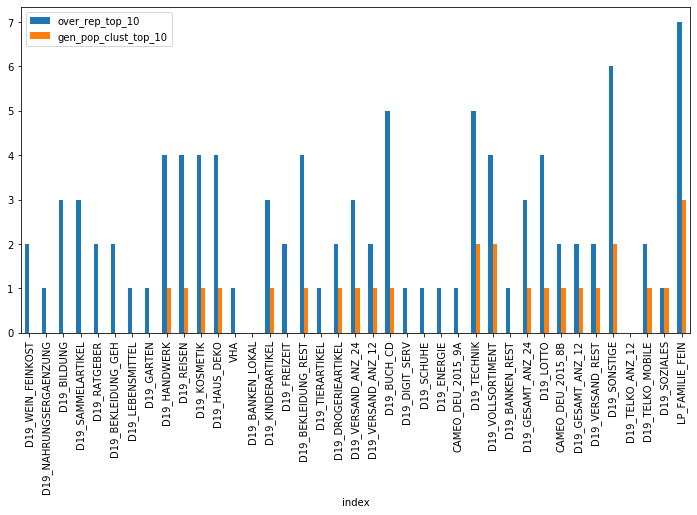

In [84]:
ind = np.abs(sort_diff2).sort_values(ascending=False)[1:40].index
over_rep_top_10 = over_rep_df[ind].mean().round()
gen_pop_clust_top_10 = gen_pop_clust_df[ind].mean().round()
compare_dict = {'index': list(ind), 'over_rep_top_10': over_rep_top_10, 'gen_pop_clust_top_10': gen_pop_clust_top_10}
compare_df = pd.DataFrame(compare_dict)
compare_df.plot(x='index', y = ['over_rep_top_10', 'gen_pop_clust_top_10'], kind='bar', figsize=(12,6))

In [87]:
sort_diff3 = new_df_2.pct_change(axis='columns')[1].sort_values()

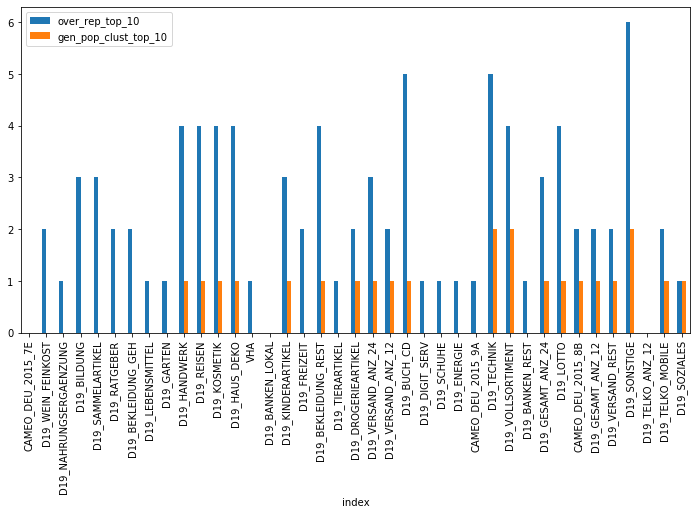

In [88]:
ind = np.abs(sort_diff3).sort_values(ascending=False)[1:40].index
over_rep_top_10 = over_rep_df[ind].mean().round()
gen_pop_clust_top_10 = gen_pop_clust_df[ind].mean().round()
compare_dict = {'index': list(ind), 'over_rep_top_10': over_rep_top_10, 'gen_pop_clust_top_10': gen_pop_clust_top_10}
compare_df = pd.DataFrame(compare_dict)
compare_df.plot(x='index', y = ['over_rep_top_10', 'gen_pop_clust_top_10'], kind='bar', figsize=(12,6))

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [91]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
# mailout_train = pd.read_csv('df_train.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [93]:
if 'Unnamed: 0' in mailout_train.columns:
    mailout_train.drop(['Unnamed: 0'], axis=1, inplace= True)

In [92]:
mailout_train.head()

Unnamed: 0   LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0           0  1763         2         1.0       8.0          NaN          NaN   
1           1  1771         1         4.0      13.0          NaN          NaN   
2           2  1776         1         1.0       9.0          NaN          NaN   
3           3  1460         2         1.0       6.0          NaN          NaN   
4           4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ...  VK_DHT4A  VK_DISTANZ  \
0          NaN          NaN                   8.0  ...       5.0         2.0   
1          NaN          NaN                  13.0  ...       1.0         2.0   
2          NaN          NaN                   7.0  ...       6.0         4.0   
3          NaN          NaN                   6.0  ...       8.0        11.0   
4          NaN          NaN                   9.0  ...       2.0         2.0   

   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  RESPONSE  \
0      1.0             6.0             9.0       3.0         3         0   
1      1.0             4.0             9.0       7.0         1         0   
2      2.0             NaN             9.0       2.0         3         0   
3     11.0             6.0             9.0       1.0         3         0   
4      1.0             6.0             9.0       3.0         3         0   

  ANREDE_KZ ALTERSKATEGORIE_GROB  
0         2                    4  
1         2                    3  
2         1                    4  
3         2                    4  
4         1                    3  

[5 rows x 368 columns]

In [106]:
mailout_train_clean = clean_data(mailout_train)

initial (42962, 367)
after findNans (42962, 367)
r2= 0.703814760808833
MSE= 0.8065283917035022
after removing some rows (35000, 362)
after removing percent_NaN (35000, 361)
after OST_WEST_KZ (35000, 361)
after engineering EINGEFUEGT Features
after engineering wealth, life_stage
after engineering Movement and Decade
after engineering FEIN_wealth,stat,age and GROB_wealth,stat
before hot encoding (35000, 369)
after hot encoding (35000, 446)
after engineering sum, min, max, etc features


In [115]:
features = [c for c in mailout_train_clean.columns if c not in ['RESPONSE']]
response = mailout_train_clean['RESPONSE']

In [251]:
training_imp = imp.transform(mailout_train_clean[features])
training_scaled = scaler.transform(training_imp)
training_scaled_df = pd.DataFrame(data= training_scaled, columns=mailout_train_clean[features].columns)
training_pca = pca.transform(training_scaled)
training_clusters = final_model.predict(training_pca)

In [164]:
mailout_train_clean['cluster'] = training_clusters

In [253]:
training_scaled_df['cluster'] = training_clusters

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [200]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
# mailout_test = pd.read_csv('df_test.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [201]:
if 'Unnamed: 0' in mailout_test.columns:
    mailout_test.drop(['Unnamed: 0'], axis=1, inplace= True)

In [207]:
mailout_test_clean = clean_data(mailout_test, no_del=False)

initial (42833, 366)
after findNans (42833, 366)
r2= 0.7111432304253538
MSE= 0.7785144398246994
after OST_WEST_KZ (42833, 360)
after engineering EINGEFUEGT Features
after engineering wealth, life_stage
after engineering Movement and Decade
after engineering FEIN_wealth,stat,age and GROB_wealth,stat
before hot encoding (42833, 368)
after hot encoding (42833, 445)
after engineering sum, min, max, etc features


In [249]:
testing_imp = imp.transform(mailout_test_clean[features])
testing_scaled = scaler.transform(testing_imp)
testing_scaled_df = pd.DataFrame(data= testing_scaled, columns=mailout_test_clean[features].columns)
testing_pca = pca.transform(testing_scaled)
testing_clusters = final_model.predict(testing_pca)

In [209]:
mailout_test_clean['cluster'] = testing_clusters

In [254]:
testing_scaled_df['cluster'] = testing_clusters

In [169]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [258]:
features.append('cluster')

In [214]:
folds = StratifiedKFold(n_splits=20, shuffle=False, random_state=42)
oof = np.zeros(len(mailout_train_clean))
predictions = np.zeros(len(mailout_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(mailout_train_clean.values, response.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(mailout_train_clean.iloc[trn_idx][features], label=response.iloc[trn_idx])
    val_data = lgb.Dataset(mailout_train_clean.iloc[val_idx][features], label=response.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(mailout_train_clean.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(mailout_test_clean[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(response, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.945226	valid_1's auc: 0.834192
[2000]	training's auc: 0.973461	valid_1's auc: 0.828724
[3000]	training's auc: 0.987494	valid_1's auc: 0.807824
[4000]	training's auc: 0.994014	valid_1's auc: 0.802145
Early stopping, best iteration is:
[1165]	training's auc: 0.951003	valid_1's auc: 0.842026
Fold 1
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.943227	valid_1's auc: 0.751196
[2000]	training's auc: 0.973302	valid_1's auc: 0.754929
[3000]	training's auc: 0.987145	valid_1's auc: 0.75485
[4000]	training's auc: 0.99428	valid_1's auc: 0.749698
Early stopping, best iteration is:
[1687]	training's auc: 0.966135	valid_1's auc: 0.761396
Fold 2
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.944791	valid_1's auc: 0.646617
[2000]	training's auc: 0.973337	valid_1's auc: 0.675351
[3000]	training's auc: 0.987266	valid_1's auc: 

Fold 19
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.942062	valid_1's auc: 0.809882
[2000]	training's auc: 0.972909	valid_1's auc: 0.823468
[3000]	training's auc: 0.987286	valid_1's auc: 0.805859
Early stopping, best iteration is:
[131]	training's auc: 0.926739	valid_1's auc: 0.84127
CV score: 0.68300 


In [213]:
print("CV score: {:<8.5f}".format(roc_auc_score(response, oof)))

CV score: 0.68805 


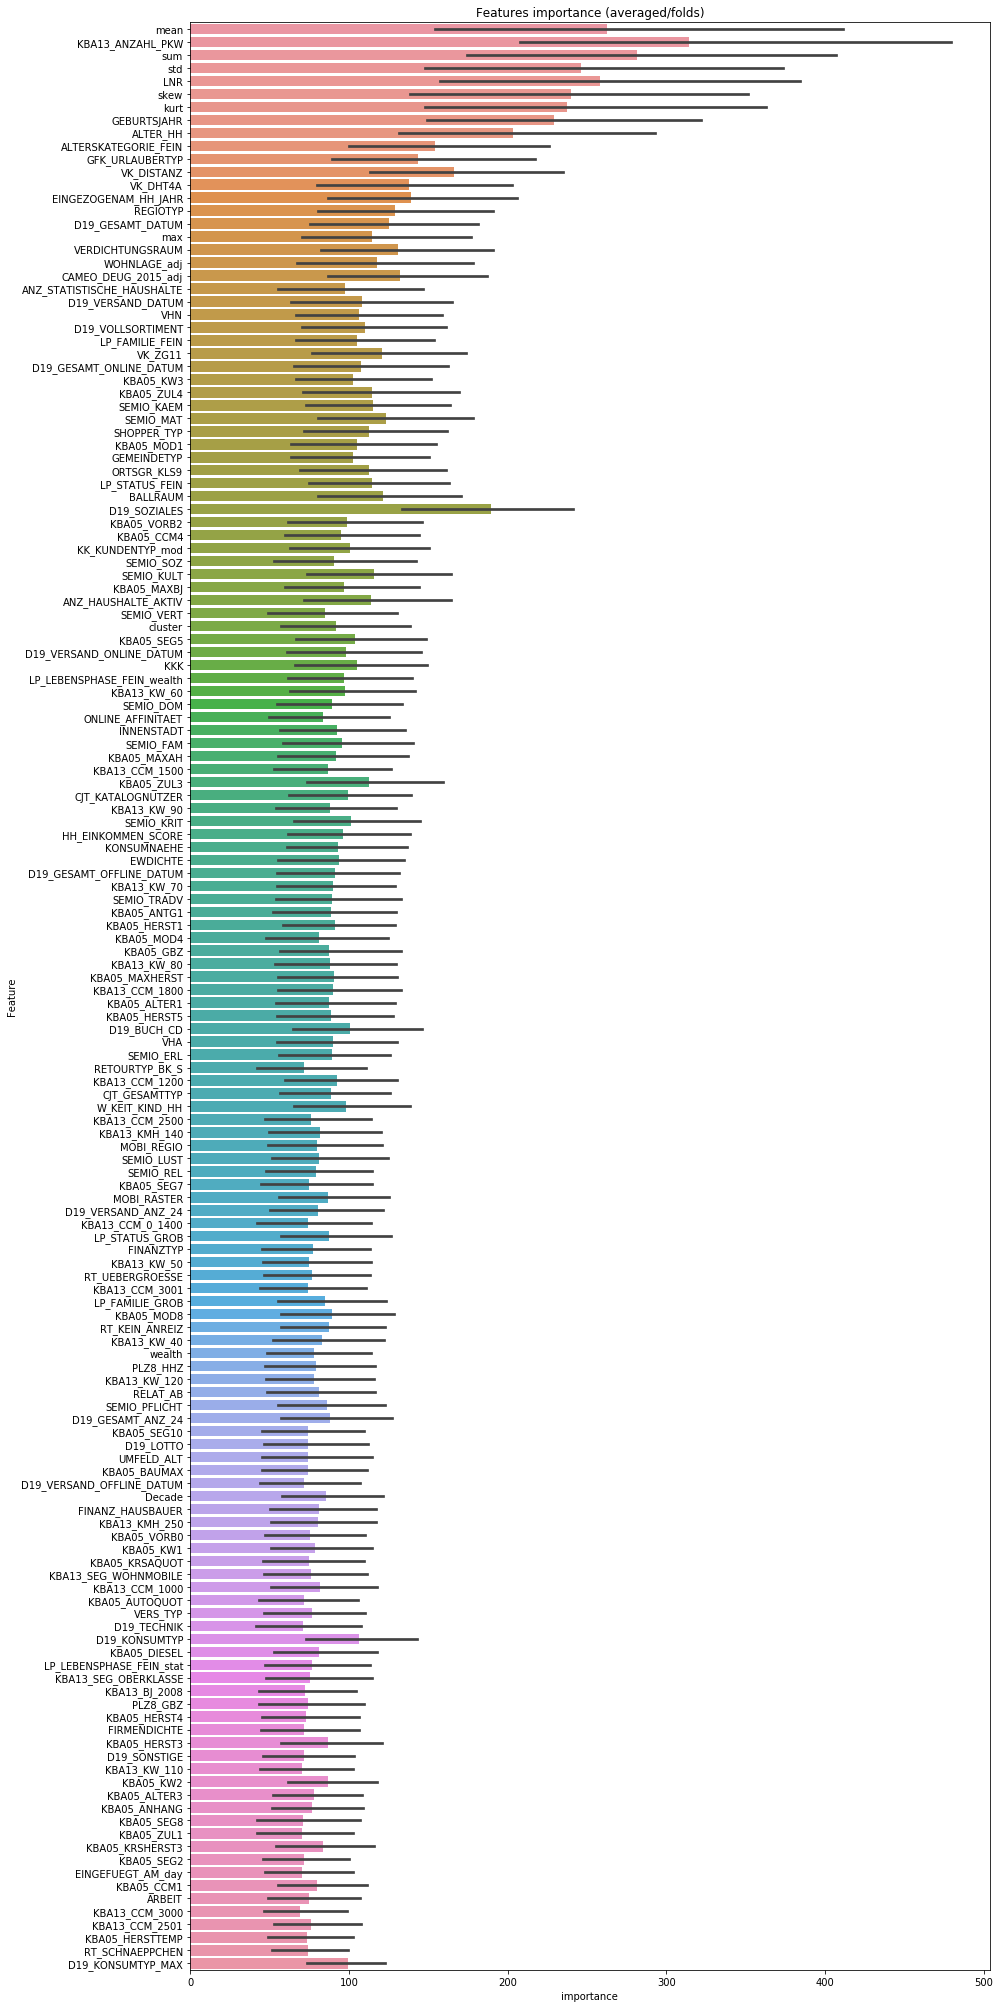

In [237]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [220]:
mailout_test_clean['RESPONSE'] = predictions

In [225]:
mailout_test_clean.rename(columns={'pred': 'RESPONSE'}, inplace= True)

In [227]:
(mailout_test_clean[['LNR', 'RESPONSE']]).to_csv('x.csv', index= False)